# Exploration strategies for DQN algorithm

In this assignment we are interested in exploration strategies that can be combined with Q-learning.
Q-learning is an off-policy algorithm, which means that the data for the algorithm can be collected by a different policy (called behavioural policy) that the one the algorithm learns.

Here we come across a classical trade-off in reinforcement learning, called exploration-exploitation trade-off. On the one hand, our behavioural policy should try out new state-action pairs to gain knowledge about their returns. On the other hand, when our estimate of returns is good enough, we would like to follow the state-action pairs with the highest estimated returns.

We will be operating on DQN [(Mnih 2014)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) algorithm and analyzing epsilon-greedy strategy, boltzmann and max-boltzmann strategy and combination of epsilon-greedy and boltzmann.
We evaluate performance of DQN variants on the Lunar Lander environment.

We provide an implementation of the DQN algorithm with random exploration strategy.
Your goal is to implement the exploration variants by overriding appropriate methods of the provided class.


## Grading

To obtain the points for the assignment You need to provide the implementation of exploration techniques AND report with plots and conclusions.
Measuring sensitivity means that You should at least examine one reasonably lower and one reasonably greater value of the considered hyperparameter (or the pair of hyperparameters).


1. Implement epsilon-greedy strategy and investigate hyperparameter sensitivity (1 point).
2. Implement epsilon-greedy strategy with epsilon annealing and investigate hyperparameter sensitivity (1 point).
3. Implement boltzmann strategy and investigate hyperparameter sensitivity (1 point).
4. Implement boltzmann strategy with temperature annealing and investigate hyperparameter sensitivity (1 point).
5. Implement max-boltzmann strategy and investigate hyperparameter sensitivity (1 point).
6. Implement max-boltzmann strategy with temperature annealing and investigate hyperparameter sensitivity (1 point).
7. Implement combination of epsilon-greedy with epsilon annealing and boltzmann strategy and investigate hyperparameter sensitivity (1 point)
8. (*) Bonus: propose another reasonable approach to combine epsilon-greedy with epsilon annealing strategy and boltzmann strategy and/or another reasonable strategy of temperature annealing for the boltzmann strategy (2 points).
9. Compare methods, present plots and conclusions in a clear manner (3 points).

You can obtain max 10 points, bonus points increase Your score, if You lose points in some other tasks.

Here we import necessary libraries.

In [ ]:
# from google.colab import drive # TODO: comment
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install swig
!pip install gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (919 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

In [ ]:
import torch
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

Here we set hyperparameters of the training, set seeds for reproducibility and set weights initialization.
Although for debugging it might be useful to operate on a smaller number of training_steps, seeds etc., in the final evaluation DO NOT CHANGE these parameters.

In [ ]:
class parse_args:
  def __init__(self):
    self.n_seeds = 6
    self.n_evaluate_episodes = 5
    self.n_training_steps = 100000
    self.buffer_size = 10000
    self.init_steps = 10000
    self.target_update_freq = 50
    self.eval_freq = 1000
    self.gym_id = "LunarLander-v3"
    env = gym.make(self.gym_id)
    self.state_dim = env.observation_space.shape[0]
    self.batch_size = 128
    self.hidden_dim = 128
    self.action_dim = env.action_space.n
    self.discount = 0.99
    self.lr = 7e-4
    self.cuda = True
    self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")

args = parse_args()
first_half_training_args = parse_args()
first_half_training_args.n_training_steps = first_half_training_args.n_training_steps // 2
second_half_training_args = parse_args()
second_half_training_args.n_training_steps = second_half_training_args.n_training_steps // 2
second_half_training_args.init_steps = 1

In [ ]:
def set_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)

def weight_init(model):
  torch.nn.init.orthogonal_(model.weight.data)
  model.bias.data.fill_(0.0)

Here we implement the replay buffer.
It has two methods: add one transition to the buffer and sample batch of transitions from the buffer.

In [ ]:
class ReplayBuffer:
  def __init__(self, args):
    self.states = np.zeros((args.buffer_size, args.n_seeds, args.state_dim), dtype = np.float32)
    self.actions = np.zeros((args.buffer_size, args.n_seeds), dtype = np.int64)
    self.rewards = np.zeros((args.buffer_size, args.n_seeds), dtype = np.float32)
    self.next_states = np.zeros((args.buffer_size, args.n_seeds, args.state_dim), dtype = np.float32)
    self.terminals = np.zeros((args.buffer_size, args.n_seeds), dtype = np.int64)
    self.idx = 0
    self.current_size = 0
    self.args = args

  def add(self, state, action, reward, next_state, terminal):
    if self.current_size < self.args.buffer_size:
      self.current_size += 1
    self.states[self.idx, :, :] = state
    self.actions[self.idx, :] = action
    self.rewards[self.idx, :] = reward
    self.next_states[self.idx, :, :] = next_state
    self.terminals[self.idx, :] = terminal
    self.idx = (self.idx + 1) % self.args.buffer_size

  def sample(self):
    sample_idxs = np.random.permutation(self.current_size)[:self.args.batch_size]
    states = torch.from_numpy(self.states[sample_idxs]).to(self.args.device)
    actions = torch.from_numpy(self.actions[sample_idxs]).to(self.args.device)
    rewards = torch.from_numpy(self.rewards[sample_idxs]).to(self.args.device)
    next_states = torch.from_numpy(self.next_states[sample_idxs]).to(self.args.device)
    terminals = torch.from_numpy(self.terminals[sample_idxs]).to(self.args.device)

    return states, actions, rewards, next_states, terminals


Here we implement a simple Q network architecture with three layers and ReLU activations.

In [ ]:
class QNetwork(torch.nn.Module):
  def __init__(self, args):
    super(QNetwork, self).__init__()
    self.layer_1 = torch.nn.Linear(args.state_dim, args.hidden_dim)
    self.layer_2 = torch.nn.Linear(args.hidden_dim, args.hidden_dim)
    self.layer_3 = torch.nn.Linear(args.hidden_dim, args.action_dim)
    self.relu = torch.nn.ReLU()

    self.layer_1.apply(weight_init)
    self.layer_2.apply(weight_init)
    self.layer_3.apply(weight_init)

  def forward(self, x):
    x = self.relu(self.layer_1(x))
    x = self.relu(self.layer_2(x))
    x = self.layer_3(x)

    return x

Here we provide code for DQN with random exploration.

In [ ]:
TRAIN_SEED = 0
EVAL_SEED = 1

class DQN:
  def __init__(self, args):
    self.args = args
    self.discount = self.args.discount
    self.reset()
    self.annealing = False

  # Copying parameters of other DQN class by reference (for half epsion-greedy, half boltzmann task)
  def copy_reference(self, other):
    self.buffer = other.buffer
    self.q_net = other.q_net
    self.q_target = other.q_target
    self.optimizer = other.optimizer

  # Annealing of epsilon and/or temperature
  def anneal(self, step):
    pass

  # Greedy action
  def get_greedy_action(self, states):
    with torch.no_grad():
      action = torch.argmax(self.q_net(states), dim = -1).detach().cpu().numpy()
      return action

  # Exploration action choice
  def explore(self, states):
    # Random action choice
    action = np.random.randint(self.args.action_dim, size = self.args.n_seeds)
    return action

  # Update of the main critic
  def update(self):
    states, actions, rewards, next_states, terminals = self.buffer.sample()
    with torch.no_grad():
      q_next_states = torch.max(self.q_target(next_states), dim = -1)[0]
    ones_tensor = torch.ones_like(terminals).to(self.args.device)
    targets = rewards + (ones_tensor - terminals) * self.discount * q_next_states

    self.optimizer.zero_grad()
    q_values = self.q_net(states).gather(-1, actions.unsqueeze(-1)).squeeze(-1)
    loss = torch.mean((q_values - targets) ** 2)
    loss.backward()
    self.optimizer.step()

  # Update of the targer critic
  def update_target(self):
    self.q_target.load_state_dict(self.q_net.state_dict())

  # Evaluation of the performance on test environments.
  def evaluate(self):
    eval_results = np.zeros(self.args.n_seeds)
    with torch.no_grad():
      eval_env = gym.make_vec(self.args.gym_id, num_envs = self.args.n_seeds, vectorization_mode="sync")
      eval_env.reset(seed = EVAL_SEED)
      for _ in range(self.args.n_evaluate_episodes):
        state, info = eval_env.reset()
        episode_reward = np.zeros(self.args.n_seeds)
        mask = np.ones(self.args.n_seeds)
        while np.sum(mask) > 0:
          action = self.get_greedy_action(torch.tensor(state).to(self.args.device))
          next_state, reward, terminal, truncated, _ = eval_env.step(action)
          episode_reward += mask * reward
          state = next_state
          mask *= (np.ones(self.args.n_seeds) - terminal) * (np.ones(self.args.n_seeds) - truncated)
        eval_results += episode_reward / self.args.n_evaluate_episodes
    return np.mean(eval_results), np.std(eval_results)


  # Resetting the algorithm
  def reset(self):
    self.buffer = ReplayBuffer(self.args)
    self.q_net = QNetwork(self.args).to(self.args.device) # main critic
    self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr = self.args.lr, eps = 1e-5)
    self.q_target = QNetwork(self.args).to(self.args.device) # target critic
    self.update_target()

  # Training loop
  def train(self):
    eval_results_means = np.array([])
    eval_results_stds = np.array([])
    train_env = gym.make_vec(self.args.gym_id, num_envs = self.args.n_seeds, vectorization_mode="sync")
    state, info = train_env.reset(seed = TRAIN_SEED)
    mask = np.ones(self.args.n_seeds)
    for step in range(self.args.n_training_steps):
      action = self.explore(torch.tensor(state).unsqueeze(0).to(self.args.device))
      if self.annealing:
        self.anneal(step)
      next_state, reward, terminal, truncated, _ = train_env.step(action)
      self.buffer.add(state, action, reward, next_state, terminal)
      state = next_state
      if step % self.args.eval_freq == 0:
          print(f"Training step: {step}")
          eval_mean, eval_std = self.evaluate()
          print(f"Eval mean: {eval_mean}; eval_std: {eval_std}")
          eval_results_means = np.append(eval_results_means, eval_mean)
          eval_results_stds = np.append(eval_results_stds, eval_std)
      if step >= self.args.init_steps:
        self.update()
        if step % self.args.target_update_freq == 0:
          self.update_target()
      mask *= (np.ones(self.args.n_seeds) - terminal) * (np.ones(self.args.n_seeds) - truncated)
      if np.sum(mask) == 0:
        state, info = train_env.reset()
        mask = np.ones(self.args.n_seeds)

    return eval_results_means, eval_results_stds


Here we implement functions for plotting.

In [ ]:
def smooth(data, weigth = 0.9):
  smooth_data = np.copy(data)
  for index in range(1, len(data)):
    smooth_data[index] = smooth_data[index - 1] * weigth + data[index] * (1.0 - weigth)

  return smooth_data

def plot_smooth(args, result_means, result_stds):
  smooth_result_means = smooth(result_means)
  smooth_result_stds = smooth(result_stds)
  print(smooth_result_means)
  print(smooth_result_stds)
  xs = np.arange(len(result_means)) * args.eval_freq
  print(xs)
  plt.plot(xs, smooth_result_means, color = "blue")
  plt.fill_between(xs, smooth_result_means - smooth_result_stds, smooth_result_means + smooth_result_stds, alpha = 0.2, label = "smoothed_rewards")
  plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
  plt.show()
  plt.clf()

def plot_smooth_many(args, result_means_list, result_stds_list, names_list, colours_list):
  plt.figure(figsize=(12.8, 9.6))
  for result_means, result_stds, name, colour in zip(result_means_list, result_stds_list, names_list, colours_list):
    smooth_result_means = smooth(result_means)
    smooth_result_stds = smooth(result_stds)
    print(smooth_result_means)
    print(smooth_result_stds)
    xs = np.arange(len(result_means)) * args.eval_freq
    print(xs)
    plt.plot(xs, smooth_result_means, color = colour)
    plt.fill_between(xs, smooth_result_means - smooth_result_stds, smooth_result_means + smooth_result_stds, alpha = 0.2, color = colour, label = f"smoothed_rewards_{name}")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
  plt.show()
  plt.clf()

def plot_results(result_mean, result_std):
  plot_smooth(args, result_mean, result_std)

def plot_results_many(result_means_list, result_stds_list, name_list, colours_list):
  plot_smooth_many(args, result_means_list, result_stds_list, name_list, colours_list)

Here we provide code for training across different random seeds.

In [ ]:
def train_dqn(dqn):
  set_seed(TRAIN_SEED)
  dqn.reset()
  result_mean, result_std = dqn.train()
  print(result_mean)
  return result_mean, result_std


Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -92.09635353225616; eval_std: 7.427149523591686
Training step: 12000
Eval mean: -139.72535441078307; 

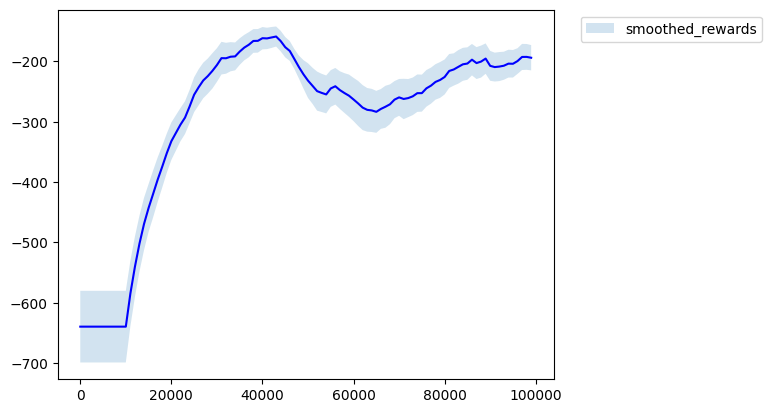

<Figure size 640x480 with 0 Axes>

In [ ]:
dqn = DQN(args)
result_means_dqn, result_stds_dqn = train_dqn(dqn)
plot_results(result_means_dqn, result_stds_dqn)

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/result_means_dqn.npy', result_means_dqn)
# np.save('/content/drive/MyDrive/hw4_data/result_stds_dqn.npy', result_stds_dqn)

## EpsilonGreedy

Here the goal is to implement the epsilon-gredy strategy. With probability epsilon we choose uniformly a random action and with probability 1-epsilon we take the action with the highest Q-value according to the main critic.

In [ ]:
class EpsilonGreedyDQN(DQN):
  def __init__(self, args, epsilon=0.1):
    super(EpsilonGreedyDQN, self).__init__(args)
    self.epsilon = epsilon # investigate sensitivity

  def explore(self, states):
    action = None
    # TODO
    ####################################
    if torch.rand((1,)).item() < self.epsilon:
      action = super(EpsilonGreedyDQN, self).explore(states)
    else:
      greedy_actions = self.get_greedy_action(states)
      return greedy_actions[0] # we want it to work with gymenv which requires non-batched data
    ####################################
    return action

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: 189.75904563979734; eval_std: 18.926452622619216
Training step: 12000
Eval mean: -124.91823362141285;

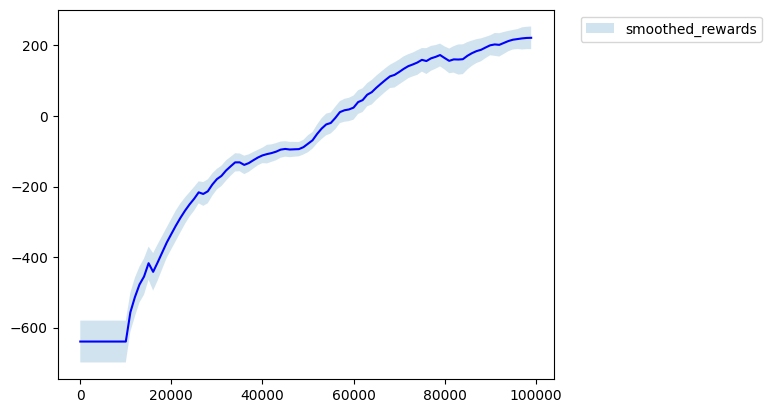

<Figure size 640x480 with 0 Axes>

In [ ]:
epsilon_greedy_dqn = EpsilonGreedyDQN(args)
result_means_epsilon_greedy_dqn, result_stds_epsilon_greedy_dqn = train_dqn(epsilon_greedy_dqn)
plot_results(result_means_epsilon_greedy_dqn, result_stds_epsilon_greedy_dqn)

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/result_means_epsilon_greedy_dqn.npy', result_means_epsilon_greedy_dqn)
# np.save('/content/drive/MyDrive/hw4_data/result_stds_epsilon_greedy_dqn.npy', result_stds_epsilon_greedy_dqn)

## EpsilonGreedyWithAnnealing

Here we add to the epsilon-greedy strategy epsilon annealing. We change linearly epsilon from 1.0 to the value final_epsilon during first anneal_steps steps and then it remains on the final_epsilon level.
Such an approach aims to increase the exploration level at the beginning of the training, when the Q-value estimate is poor and thus choosing greedily according to Q is not improving the performance.

In [ ]:
class EpsilonGreedyWithAnnealingDQN(EpsilonGreedyDQN):
  def __init__(self, args, final_epsilon=0.1):
    self.start_epsilon = 1.0
    super(EpsilonGreedyWithAnnealingDQN, self).__init__(args)
    self.epsilon = self.start_epsilon
    self.final_epsilon = final_epsilon # investigate sensitivity
    self.annealing = True
    self.anneal_steps = 30000

  def anneal(self, step):
    # TODO
    ####################################
    self.epsilon = self.start_epsilon - step * (self.start_epsilon - self.final_epsilon) / self.anneal_steps
    self.epsilon = max(self.final_epsilon, self.epsilon)
    ####################################

  def reset(self):
    super(EpsilonGreedyWithAnnealingDQN, self).reset()
    self.epsilon = self.start_epsilon

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -114.15075930943605; eval_std: 8.98149810557351
Training step: 12000
Eval mean: -108.27444985464808; 

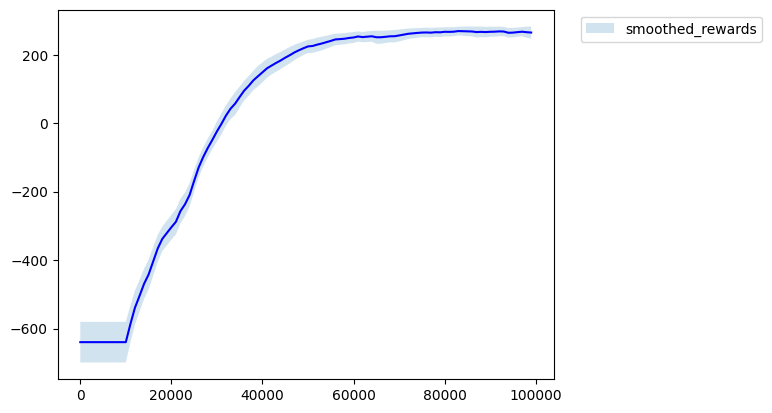

<Figure size 640x480 with 0 Axes>

In [ ]:
epsilon_greedy_with_annealing_dqn = EpsilonGreedyWithAnnealingDQN(args)
result_means_epsilon_greedy_with_annealing_dqn, result_stds_epsilon_greedy_with_annealing_dqn = train_dqn(epsilon_greedy_with_annealing_dqn)
plot_results(result_means_epsilon_greedy_with_annealing_dqn, result_stds_epsilon_greedy_with_annealing_dqn)

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/result_means_epsilon_greedy_with_annealing_dqn.npy', result_means_epsilon_greedy_with_annealing_dqn)
# np.save('/content/drive/MyDrive/hw4_data/result_stds_epsilon_greedy_with_annealing_dqn.npy', result_stds_epsilon_greedy_with_annealing_dqn)

## Boltzmann

Alternative approach to the epsilon-greedy strategy is to use so-called boltzmann exploration strategy.
The idea behind this approach is to perform softmax on the Q-values coming from the main critic and then sample from the obtained distribution.
In this approach we use softmax with a temperature, i.e. before applying softmax, we scale all the Q-values by the temperature coefficient (in the literature we usually divide by the temperature, but this is equivallent to scaling by the inverse of the temperature). Large scaling values make the distribution close to the greedy choice, while low scaling values make the distribution close to the uniform one.

In [ ]:
class BoltzmannDQN(DQN):
  def __init__(self, args, temperature=1.0):
    super(BoltzmannDQN, self).__init__(args)
    self.temperature = temperature # investigate sensitivity

  def explore(self, states):
    action = None
    with torch.no_grad():
      # TODO
      ####################################
      q_values = self.q_net(states) # (batch, n_seeds, n_actions)
      probs = torch.softmax(q_values / self.temperature, dim=-1).squeeze(0) # (n_seeds, n_actions)
      action = torch.multinomial(probs, num_samples=1).squeeze(1).detach().cpu().numpy() # (n_seeds, )
      ####################################

    return action

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -72.96729432350496; eval_std: 8.804049939226333
Training step: 12000
Eval mean: -94.90295635845973; e

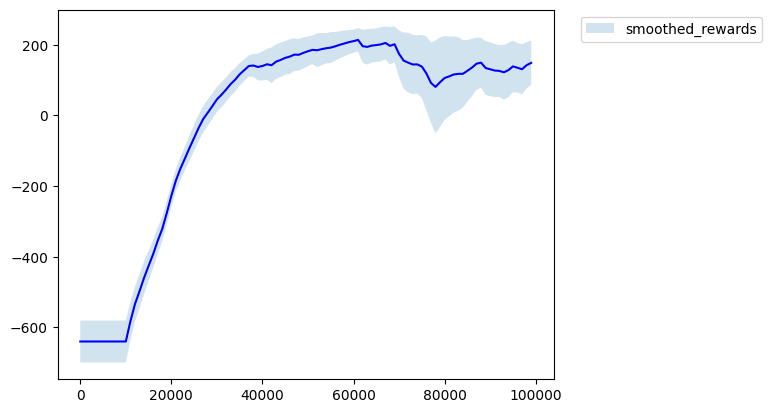

<Figure size 640x480 with 0 Axes>

In [ ]:
boltzmann_dqn = BoltzmannDQN(args)
result_means_boltzmann_dqn, result_stds_boltzmann_dqn = train_dqn(boltzmann_dqn)
plot_results(result_means_boltzmann_dqn, result_stds_boltzmann_dqn)

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/result_means_boltzmann_dqn.npy', result_means_boltzmann_dqn)
# np.save('/content/drive/MyDrive/hw4_data/result_stds_boltzmann_dqn.npy', result_stds_boltzmann_dqn)

## MaxBoltzmann

One of the compromises between epsilon-greedy and boltzmann exploration strategy is so-calles max-boltzmann strategy. In this strategy with probability 1-epsilon we choose action greedily, but with probability epsilon we perform the boltzmann choice instead of the uniform random choice.

In [ ]:
class MaxBoltzmannDQN(EpsilonGreedyWithAnnealingDQN):
  def __init__(self, args, temperature=0.1):
    super(MaxBoltzmannDQN, self).__init__(args)
    self.temperature = temperature # investigate sensitivity

  def explore(self, states):
    action = None
    with torch.no_grad():
      # TODO
      ####################################
      if torch.rand((1,)).item() < self.epsilon:
        q_values = self.q_net(states) # (batch, n_seeds, n_actions)
        probs = torch.softmax(q_values / self.temperature, dim=-1).squeeze(0) # (n_seeds, n_actions)
        action = torch.multinomial(probs, num_samples=1).squeeze(1).detach().cpu().numpy() # (n_seeds, )
      else:
        greedy_actions = self.get_greedy_action(states)
        action = greedy_actions[0] # we want it to work with gymenv which requires non-batched data
      ####################################
    return action

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: 18.88678819146656; eval_std: 11.797319617743986
Training step: 12000
Eval mean: -109.1552185820156; e

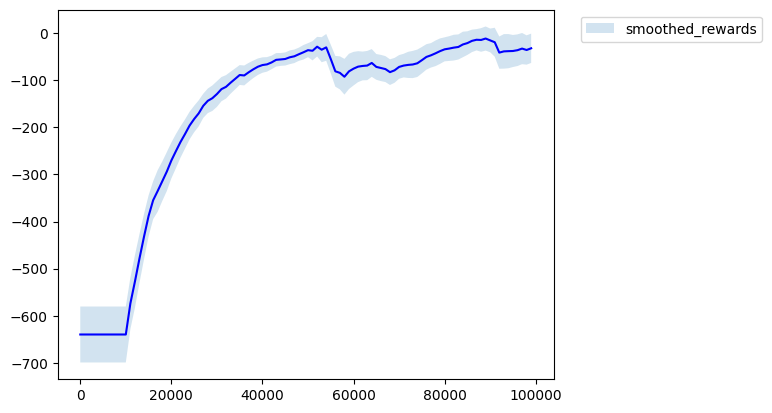

<Figure size 640x480 with 0 Axes>

In [ ]:
max_boltzmann_dqn = MaxBoltzmannDQN(args)
result_means_max_boltzmann_dqn, result_stds_max_boltzmann_dqn = train_dqn(max_boltzmann_dqn)
plot_results(result_means_max_boltzmann_dqn, result_stds_max_boltzmann_dqn)

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/result_means_max_boltzmann_dqn.npy', result_means_max_boltzmann_dqn)
# np.save('/content/drive/MyDrive/hw4_data/result_stds_max_boltzmann_dqn.npy', result_stds_max_boltzmann_dqn)

## MaxBoltzmannWithTemperatureAnnealing

Similarly to adjusting the value of epsilon in epsilon-greedy strategy, we can adjust the temperature in the max-boltzmann and boltzmann strategies: we start we the value start_temperature and linearly increase the value to the final_temperature during temperature_anneal_steps, then the temperature is on the constant level.


In [ ]:
class MaxBoltzmannWithTemperatureAnnealingDQN(MaxBoltzmannDQN):
  def __init__(self, args, start_temperature=0.025, final_temperature=0.3):
    self.start_temperature = start_temperature # investigate sensitivity
    super(MaxBoltzmannWithTemperatureAnnealingDQN, self).__init__(args)
    self.temperature = self.start_temperature
    self.final_temperature = final_temperature # investigate sensitivity
    self.temperature_anneal_steps = 30000
    self.annealing = True

  def anneal(self, step):
    super(MaxBoltzmannWithTemperatureAnnealingDQN, self).anneal(step)
    # TODO
    ####################################
    self.temperature = self.start_temperature + step * (self.final_temperature - self.start_temperature) / self.temperature_anneal_steps
    self.temperature = min(self.final_temperature, self.temperature)
    ####################################

  def reset(self):
    self.temperature = self.start_temperature
    super(MaxBoltzmannWithTemperatureAnnealingDQN, self).reset()

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -0.6440109166016702; eval_std: 72.52055521210423
Training step: 12000
Eval mean: -14.027396934466466;

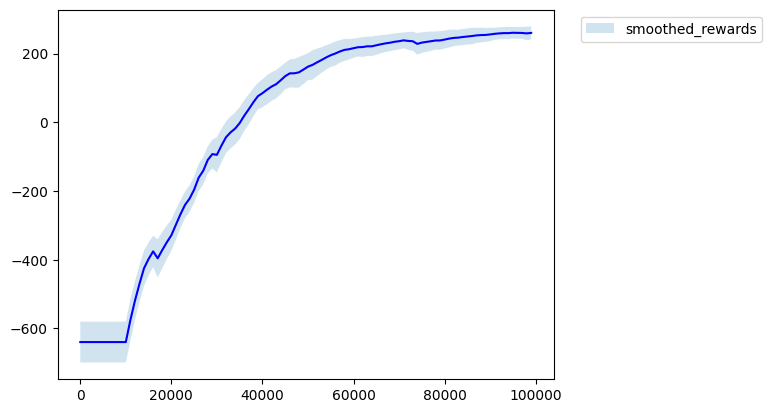

<Figure size 640x480 with 0 Axes>

In [ ]:
max_boltzmann_temp_anneal_dqn = MaxBoltzmannWithTemperatureAnnealingDQN(args)
result_means_max_boltzmann_temp_anneal_dqn, result_stds_max_boltzmann_temp_anneal_dqn = train_dqn(max_boltzmann_temp_anneal_dqn)
plot_results(result_means_max_boltzmann_temp_anneal_dqn, result_stds_max_boltzmann_temp_anneal_dqn)

In [ ]:
# # TODO: comment
# np.save('/content/drive/MyDrive/hw4_data/result_means_max_boltzmann_temp_anneal_dqn.npy', result_means_max_boltzmann_temp_anneal_dqn)
# np.save('/content/drive/MyDrive/hw4_data/result_stds_max_boltzmann_temp_anneal_dqn.npy', result_stds_max_boltzmann_temp_anneal_dqn)

## BoltzmannWithTemperatureAnnealing

In [ ]:
class BoltzmannWithTemperatureAnnealingDQN(BoltzmannDQN):
  def __init__(self, args, start_temperature=0.25, final_temperature=3.0):
    self.start_temperature = start_temperature # investigate sensitivity
    super(BoltzmannWithTemperatureAnnealingDQN, self).__init__(args)
    self.temperature = self.start_temperature
    self.final_temperature = final_temperature # investigate sensitivity
    self.temperature_anneal_steps = 30000
    self.annealing = True

  def anneal(self, step):
    # TODO
    ####################################
    self.temperature = self.start_temperature + step * (self.final_temperature - self.start_temperature) / self.temperature_anneal_steps
    self.temperature = min(self.final_temperature, self.temperature)
    ####################################

  def reset(self):
    self.temperature = self.start_temperature
    super(BoltzmannWithTemperatureAnnealingDQN, self).reset()

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -79.45150327807274; eval_std: 12.838445924831097
Training step: 12000
Eval mean: -162.9294573185907; 

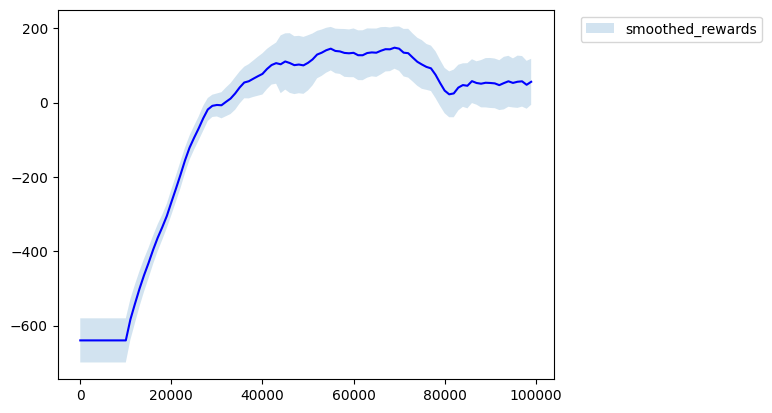

<Figure size 640x480 with 0 Axes>

In [ ]:
boltzmann_temp_anneal_dqn = BoltzmannWithTemperatureAnnealingDQN(args)
result_means_boltzmann_temp_anneal_dqn, result_stds_boltzmann_temp_anneal_dqn = train_dqn(boltzmann_temp_anneal_dqn)
plot_results(result_means_boltzmann_temp_anneal_dqn, result_stds_boltzmann_temp_anneal_dqn)

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/result_means_boltzmann_temp_anneal_dqn.npy', result_means_boltzmann_temp_anneal_dqn)
# np.save('/content/drive/MyDrive/hw4_data/result_stds_boltzmann_temp_anneal_dqn.npy', result_stds_boltzmann_temp_anneal_dqn)

## Two halves

The last exploration idea we want to implement is a combintation of the epsilon-greedy strategy (with epsilon annealing) and the boltzmann strategy.
We could think that at the beginning of the training the boltzmann strategy struggles because the Q-function (the main critic) is not yet well-trained. However, the more critic is trained, the more sense it makes to start using the boltzmann strategy. We would like to verif y this hypoothesis by using in the first half of the training epsilon-greedy strategy (with epsilon annealing) and in the second half of the training switch the exploration strategy to the boltzmann one.

In [ ]:
def train_two_halfs_dqn(dqn_1, dqn_2):
  set_seed(TRAIN_SEED)
  # TODO
  ####################################
  dqn_1.reset()
  res_mean_1, res_std_1 = dqn_1.train()

  dqn_2.copy_reference(dqn_1)
  res_mean_2, res_std_2 = dqn_2.train()

  result_mean = np.concatenate([res_mean_1, res_mean_2])
  result_std = np.concatenate([res_std_1, res_std_2])

  print(result_mean)
  ####################################

  return result_mean, result_std

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -114.15075930943605; eval_std: 8.98149810557351
Training step: 12000
Eval mean: -108.27444985464808; 

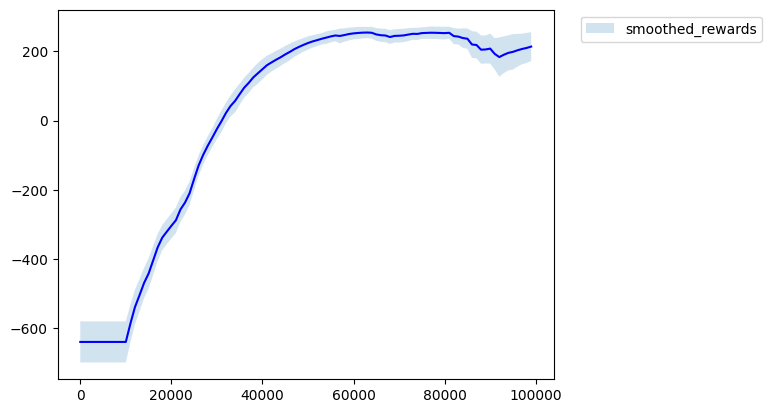

<Figure size 640x480 with 0 Axes>

In [ ]:
epsilon_greedy_with_annealing_half_dqn = EpsilonGreedyWithAnnealingDQN(first_half_training_args) # investigate sensitivity of epsilon
epsilon_greedy_boltzmann_half_dqn = BoltzmannDQN(second_half_training_args) # investigate sensitivity of temperature
result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn, result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn = train_two_halfs_dqn(epsilon_greedy_with_annealing_half_dqn, epsilon_greedy_boltzmann_half_dqn)
plot_results(result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn, result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn)

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn.npy', result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn)
# np.save('/content/drive/MyDrive/hw4_data/result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn.npy', result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn)

## Soft switch (Bonus 1)

Here, we want to examine an approach with soft switch between EpsilonGreedyWithAnnealing and Boltzmann strategy.

We define `p` as probabilty of choosing EpsilonGreedyWithAnnealing in the current step. After each step we anneal this probability.

In [ ]:
class SoftSwitchDQN(DQN):
  def __init__(self, args, start_epsilon=0.1, final_epsilon=0.05, start_temperature=0.5, final_temperature=0.1):
    self.start_epsilon = start_epsilon
    self.start_temperature = start_temperature
    super(SoftSwitchDQN, self).__init__(args)
    self.anneal_steps = 30000
    self.annealing = True

    self.final_epsilon = final_epsilon
    self.epsilon = self.start_epsilon

    self.final_temperature = final_temperature
    self.temperature = self.start_temperature

    self.internal_step = 0

    self.start_transition = 0.4 * self.args.n_training_steps
    self.end_transition = 0.6 * self.args.n_training_steps

  def anneal(self, step):
    self.epsilon = self.start_epsilon - step * (self.start_epsilon - self.final_epsilon) / self.anneal_steps
    self.epsilon = max(self.epsilon, self.final_epsilon)

    self.temperature = self.start_temperature - step * (self.start_temperature - self.final_temperature) / self.anneal_steps
    self.temperature = max(self.temperature, self.final_temperature)

  def explore(self, states):
    action = None

    # calculate the switch probability (p)
    self.internal_step += 1
    if self.internal_step < self.start_transition:
      p = 0.0
    elif self.internal_step > self.end_transition:
      p = 1.0
    else:
      p = (self.internal_step - self.start_transition) / (self.end_transition - self.start_transition)

    if torch.rand((1,)).item() > p:
      if torch.rand((1,)).item() < self.epsilon:
        action = super(SoftSwitchDQN, self).explore(states)
      else:
        greedy_actions = self.get_greedy_action(states)
        return greedy_actions[0] # we want it to work with gymenv which requires non-batched data
    else:
      with torch.no_grad():
        q_values = self.q_net(states) # (batch, n_seeds, n_actions)
        probs = torch.softmax(q_values / self.temperature, dim=-1).squeeze(0) # (n_seeds, n_actions)
        action = torch.multinomial(probs, num_samples=1).squeeze(1).detach().cpu().numpy() # (n_seeds, )

    return action

  def reset(self):
    super(SoftSwitchDQN, self).reset()
    self.internal_step = 0
    self.epsilon = self.start_epsilon
    self.temperature = self.start_temperature


## Boltzmann with Exponential Temperature Annealing (Bonus 2)

Here, we want to check if the way of annealing is significant to performance of the Boltzmann strategy.

We have Boltzmann with simple temperature annealing implemented before, here we have the same version, but with exponential temperature annealing.

In [ ]:
class BoltzmannWithExponentialTemperatureAnnealingDQN(BoltzmannDQN):
  def __init__(self, args, max_t=2.0, min_t=0.1):
    self.max_t = max_t
    super(BoltzmannWithExponentialTemperatureAnnealingDQN, self).__init__(args)
    self.min_t = min_t

    self.temperature = self.max_t

    self.decay_lambda = 5.0 / self.args.n_training_steps

    self.annealing = True

  def anneal(self, step):
    self.temperature = self.min_t + (self.max_t - self.min_t) * np.exp(-self.decay_lambda * step)

  def reset(self):
    super(BoltzmannWithExponentialTemperatureAnnealingDQN, self).reset()
    self.temperature = self.max_t

## Plots

Here we plot the results of all exploration methods on one plot. However, for drawing conclusions, it might be reasonable to plot some subsets of methods together, for example to compare variants with and without annealing, max-boltzmann with boltzmann, epsilon-greedy, boltzmann and half-epsilon-greedy, half-boltzmann.

### All together

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -584.93094833 -540.41038894 -502.02655356 -469.41877525
 -442.98386107 -419.58114552 -395.96074101 -374.44977088 -352.1386586
 -332.33201467 -318.59616157 -304.90710158 -293.23490028 -274.93554658
 -255.276022   -242.85838372 -231.68604832 -224.45580598 -215.89503083
 -206.1683148  -194.70364992 -194.87614826 -192.34174006 -191.81131886
 -183.88109052 -177.27037223 -172.50007814 -166.21921499 -166.00939292
 -161.63865365 -161.99646726 -160.41323957 -158.86445154 -166.38122149
 -176.50949756 -182.80880279 -196.06900009 -209.41384822 -221.45165621
 -231.93457148 -240.59563763 -249.36540598 -252.29110317 -254.81157206
 -244.91464277 -241.26706933 -247.64482651 -252.53360716 -256.95141324
 -263.2049298  -269.69913177 -276.68179738 -280.35784237 -281.36676816
 -283.67521521 -278.88564663 -275.25036644 -271.17252546 -263.42666507
 -259.7

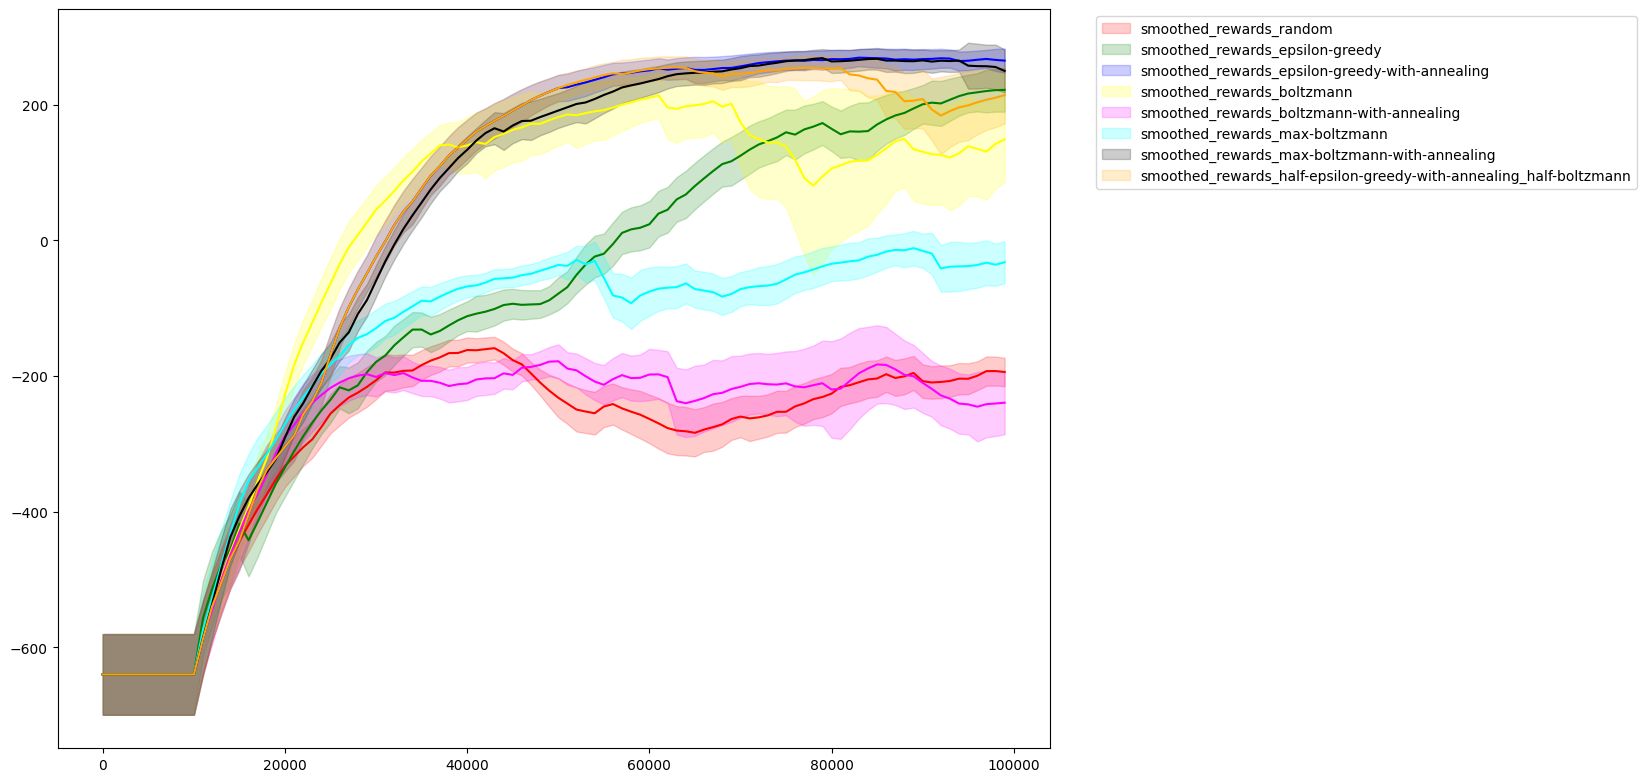

<Figure size 640x480 with 0 Axes>

In [ ]:
result_means_list = [result_means_dqn, result_means_epsilon_greedy_dqn, result_means_epsilon_greedy_with_annealing_dqn,
                result_means_boltzmann_dqn, result_means_boltzmann_temp_anneal_dqn,
                result_means_max_boltzmann_dqn, result_means_max_boltzmann_temp_anneal_dqn,
                result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn]
result_stds_list = [result_stds_dqn, result_stds_epsilon_greedy_dqn, result_stds_epsilon_greedy_with_annealing_dqn,
                result_stds_boltzmann_dqn, result_stds_boltzmann_temp_anneal_dqn,
                result_stds_max_boltzmann_dqn, result_stds_max_boltzmann_temp_anneal_dqn,
                result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn]
names_list = ["random", "epsilon-greedy", "epsilon-greedy-with-annealing",
             "boltzmann", "boltzmann-with-annealing",
             "max-boltzmann", "max-boltzmann-with-annealing",
             "half-epsilon-greedy-with-annealing_half-boltzmann"]
colours_list = ["red", "green", "blue",
           "yellow", "magenta",
           "cyan", "black",
           "orange", 'indigo']

plot_results_many(result_means_list, result_stds_list, names_list, colours_list)

### plot_by_ids function

In [ ]:
def plot_by_ids(ids):
  means = [result_means_list[i] for i in ids]
  stds = [result_stds_list[i] for i in ids]
  names = [names_list[i] for i in ids]
  colours = [colours_list[i] for i in ids]

  plot_results_many(means, stds, names, colours)

### EpsilonGreedy with and without annealing

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -556.74540841 -513.56269093 -478.07071315 -455.42646111
 -417.50191569 -442.03697292 -414.94599126 -386.78132137 -358.63081449
 -334.53736665 -310.72658067 -288.67298577 -268.55019762 -250.62681261
 -234.79880634 -216.53623227 -221.12933846 -213.57596817 -194.35992803
 -179.06800964 -169.88360981 -154.74570423 -142.93092466 -131.56403347
 -131.49199307 -138.71917986 -133.55460803 -125.43189684 -117.79955558
 -111.77768937 -108.08193563 -105.1669996  -101.13765002  -95.35329351
  -93.46406837  -95.03147676  -94.45243823  -93.96496907  -88.38784624
  -78.64316402  -68.90917883  -50.91872219  -35.66629347  -23.89263337
  -19.77610606   -5.4839662    10.98471257   16.18445027   18.58209751
   23.72611831   39.40001044   45.07770778   60.35761559   67.56577642
   80.12992603   91.32466872  102.18585152  112.37457313  116.55595687
  124.

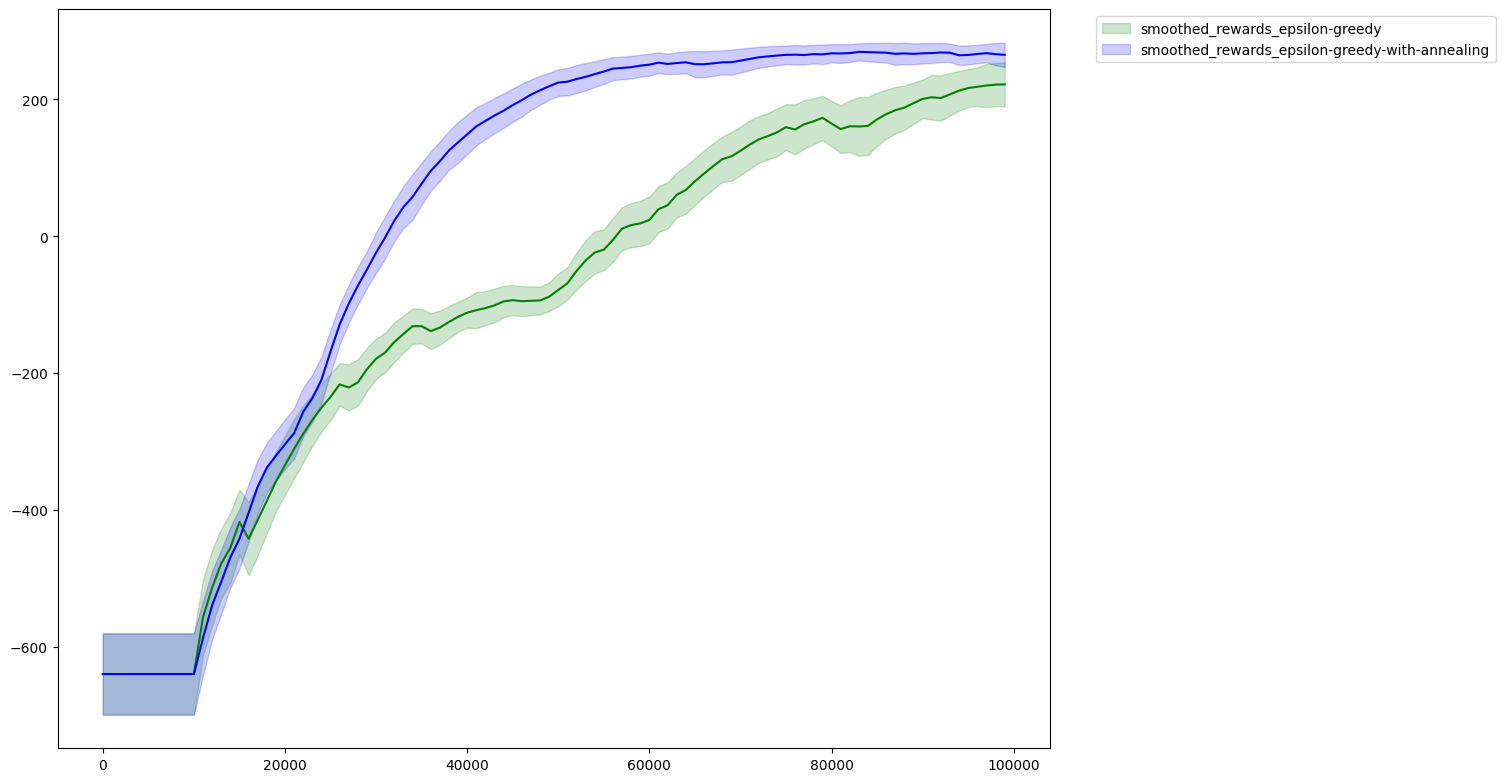

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_results_many(result_means_list[1:3], result_stds_list[1:3], names_list[1:3], colours_list[1:3])

### Boltzmann with and without anealing

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -583.01804241 -534.2065338  -497.79727628 -459.75071737
 -425.7964594  -392.55324897 -354.83461156 -321.13909862 -276.01835464
 -227.32126006 -183.97617273 -150.05882357 -121.11026148  -91.39635232
  -63.44581797  -35.0445919   -10.10098165    7.82382942   26.33712559
   45.37409254   58.38790009   72.95291536   88.4909172   100.90597634
  116.2808347   128.01145606  139.7709179   141.19935603  137.09301575
  139.83235839  144.7090535   142.02254129  152.17180347  157.02382191
  162.81732252  166.48988762  171.98582147  171.64300576  177.07735614
  181.60224496  185.53857735  184.43048676  187.49870304  190.08244266
  191.90382303  195.56811109  200.00825435  203.59609949  207.38572105
  210.1564798   213.7153394   195.85811846  193.88239637  197.56643442
  198.99837054  201.05781649  205.09642885  196.89943257  201.41421996
  173.

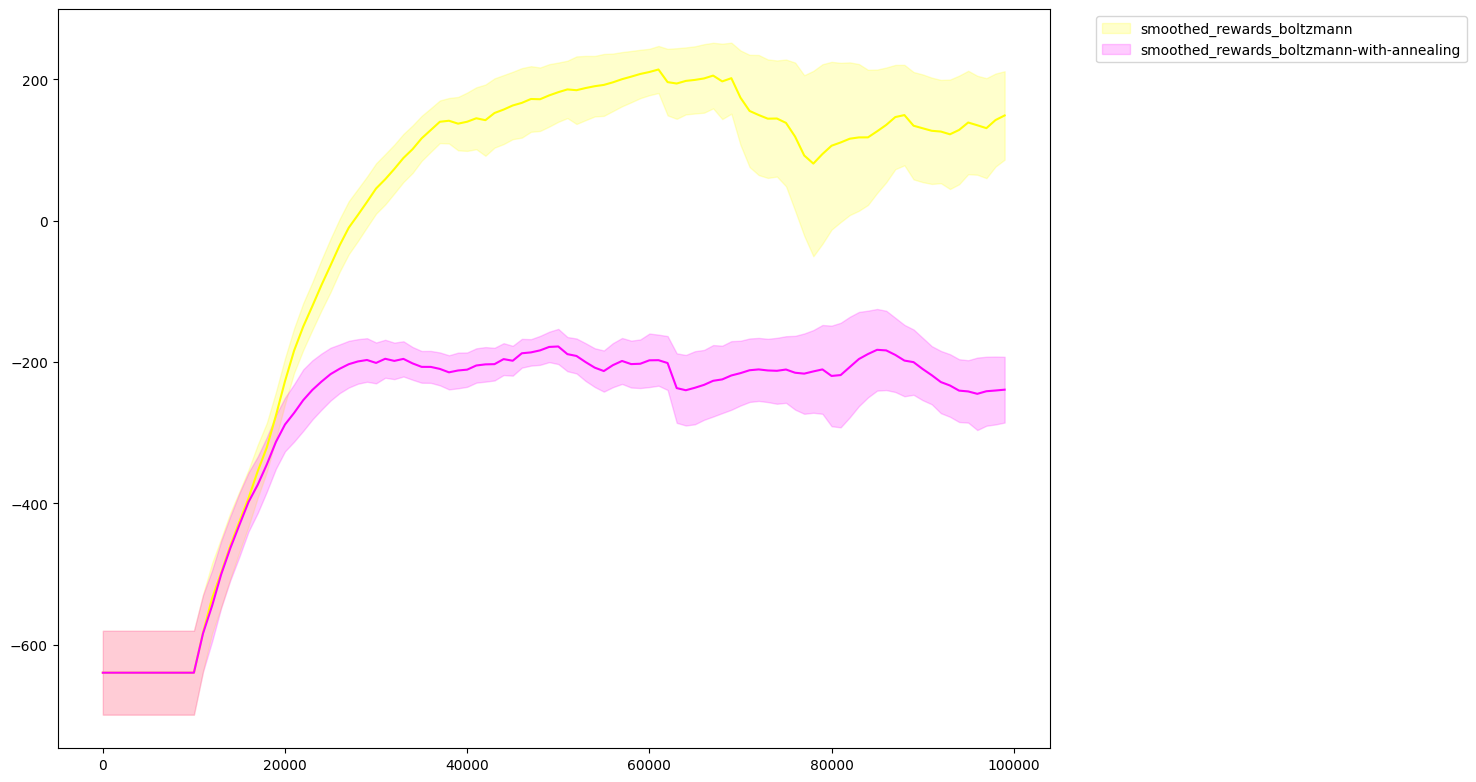

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_results_many(result_means_list[3:5], result_stds_list[3:5], names_list[3:5], colours_list[3:5])

### MaxBoltzmann with and without annealing

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -573.83263416 -527.3648926  -478.3014185  -431.85704345
 -388.21244085 -354.77182416 -335.05723542 -314.57873241 -293.9811498
 -270.39213044 -250.55746771 -231.26945038 -214.21235644 -196.29032385
 -182.42911518 -170.40448655 -154.41135552 -143.78151153 -138.20638623
 -129.41641741 -118.95636221 -114.08636304 -105.36311919  -97.23001117
  -89.00129838  -89.93348333  -83.03795919  -76.84956066  -71.38416293
  -67.86174798  -66.40581466  -62.30918773  -56.80876927  -55.93523968
  -54.96812044  -51.39152861  -49.28411652  -44.87142559  -40.75548673
  -36.27881935  -37.52040342  -28.86859364  -35.24532997  -30.3660473
  -55.06198694  -81.12313861  -84.40486996  -92.6661652   -81.2412826
  -75.50562077  -71.21480603  -69.76046634  -68.94905066  -63.41311125
  -71.77490748  -74.06918856  -76.4230623   -82.91192118  -79.10188779
  -71.833

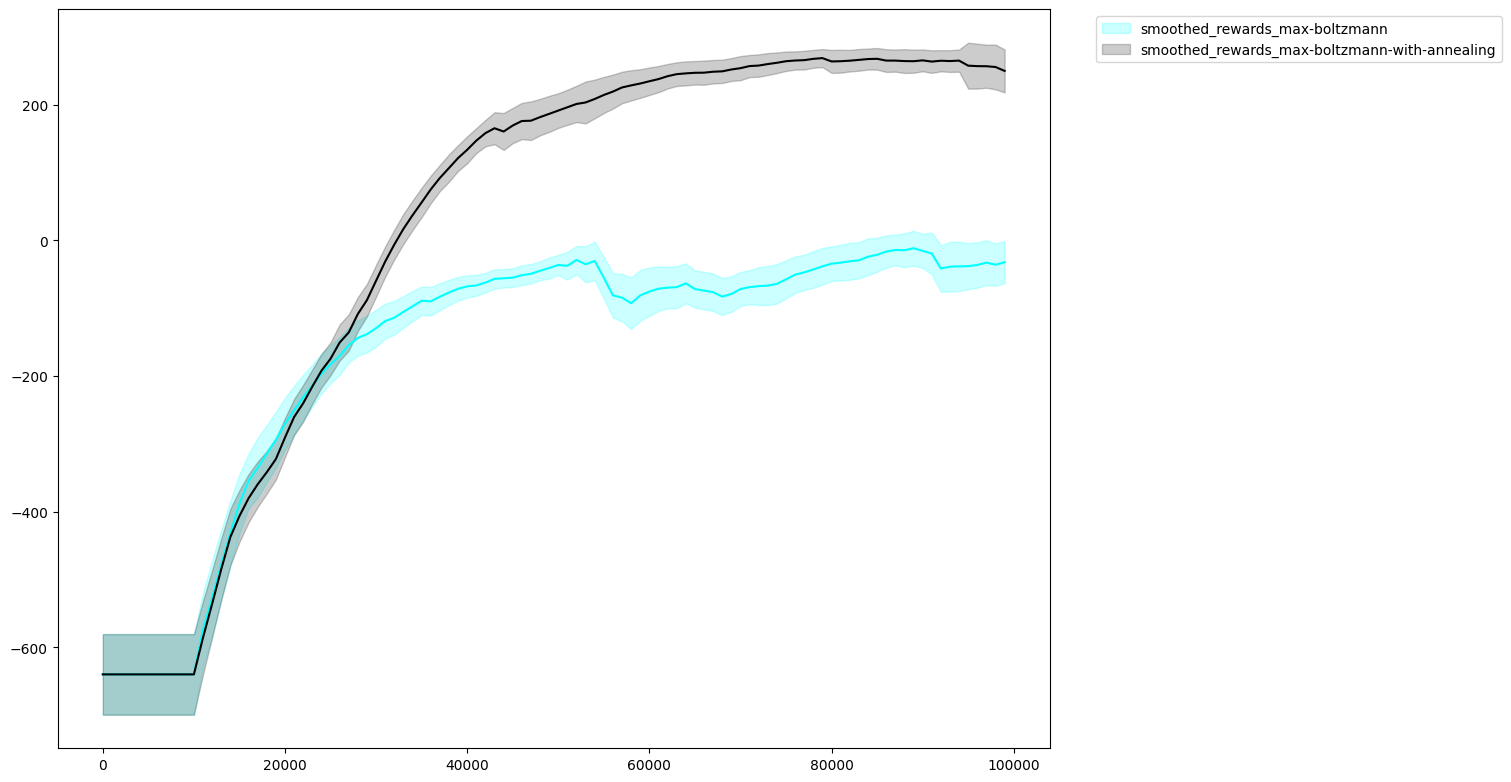

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_results_many(result_means_list[5:7], result_stds_list[5:7], names_list[5:7], colours_list[5:7])

### Boltzmann vs MaxBoltzmann

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -583.01804241 -534.2065338  -497.79727628 -459.75071737
 -425.7964594  -392.55324897 -354.83461156 -321.13909862 -276.01835464
 -227.32126006 -183.97617273 -150.05882357 -121.11026148  -91.39635232
  -63.44581797  -35.0445919   -10.10098165    7.82382942   26.33712559
   45.37409254   58.38790009   72.95291536   88.4909172   100.90597634
  116.2808347   128.01145606  139.7709179   141.19935603  137.09301575
  139.83235839  144.7090535   142.02254129  152.17180347  157.02382191
  162.81732252  166.48988762  171.98582147  171.64300576  177.07735614
  181.60224496  185.53857735  184.43048676  187.49870304  190.08244266
  191.90382303  195.56811109  200.00825435  203.59609949  207.38572105
  210.1564798   213.7153394   195.85811846  193.88239637  197.56643442
  198.99837054  201.05781649  205.09642885  196.89943257  201.41421996
  173.

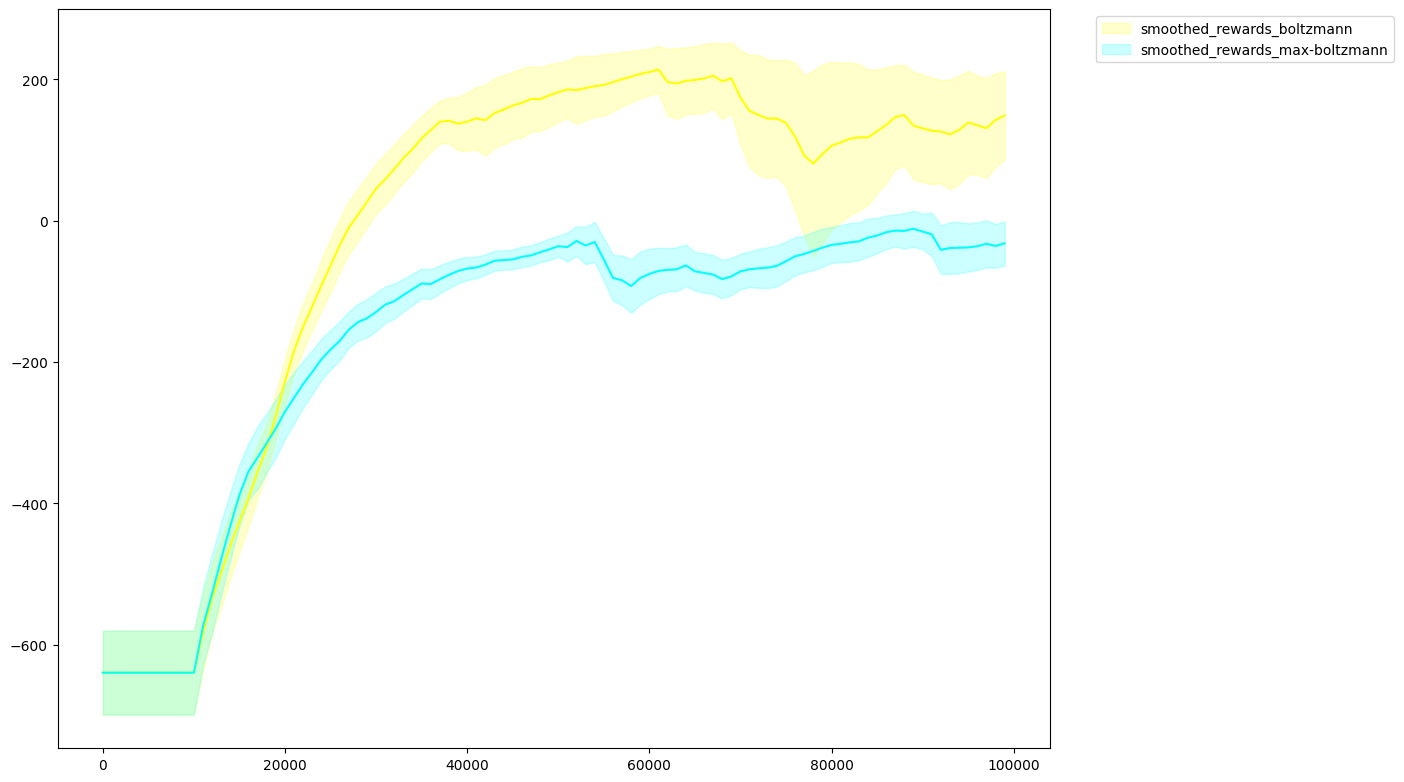

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_by_ids([3, 5])

### EpsilonGreedy, Boltzmann and half-EpsilonGreedyWithAnnealing half-Boltzmann

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -556.74540841 -513.56269093 -478.07071315 -455.42646111
 -417.50191569 -442.03697292 -414.94599126 -386.78132137 -358.63081449
 -334.53736665 -310.72658067 -288.67298577 -268.55019762 -250.62681261
 -234.79880634 -216.53623227 -221.12933846 -213.57596817 -194.35992803
 -179.06800964 -169.88360981 -154.74570423 -142.93092466 -131.56403347
 -131.49199307 -138.71917986 -133.55460803 -125.43189684 -117.79955558
 -111.77768937 -108.08193563 -105.1669996  -101.13765002  -95.35329351
  -93.46406837  -95.03147676  -94.45243823  -93.96496907  -88.38784624
  -78.64316402  -68.90917883  -50.91872219  -35.66629347  -23.89263337
  -19.77610606   -5.4839662    10.98471257   16.18445027   18.58209751
   23.72611831   39.40001044   45.07770778   60.35761559   67.56577642
   80.12992603   91.32466872  102.18585152  112.37457313  116.55595687
  124.

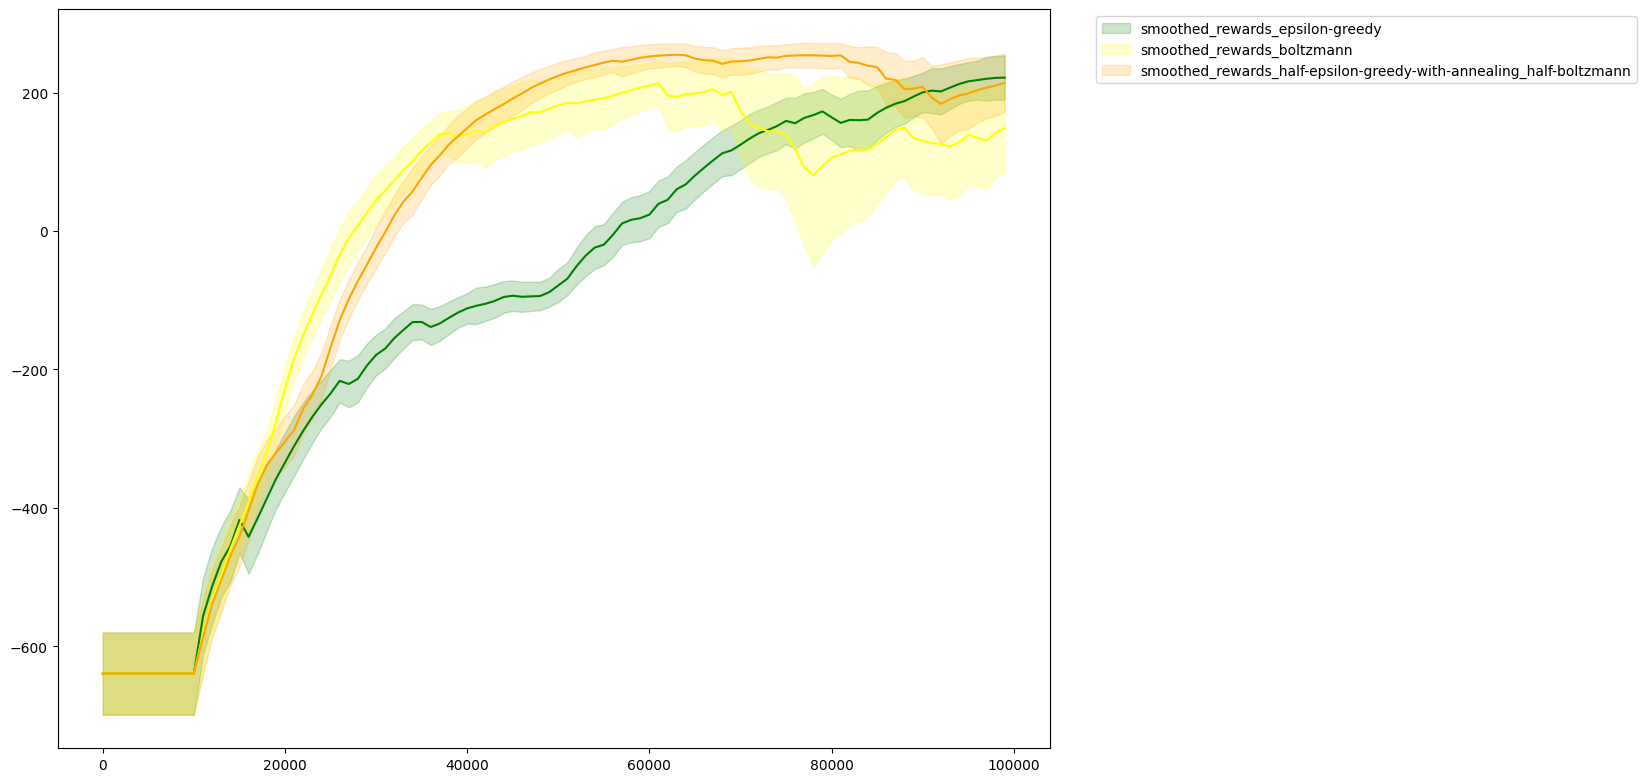

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_by_ids([1, 3, 7])

### Boltzmann with annealing vs half-EpsilonGreedyWithAnnealing half-Boltzmann

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -587.13638891 -539.250195   -504.94673243 -469.45549967
 -442.06133638 -404.29619441 -366.14932014 -338.19474775 -320.91831501
 -304.06199954 -287.90739181 -256.70164693 -236.72992551 -209.86161077
 -168.40158288 -129.01351545  -98.53401241  -72.29766643  -48.65761647
  -24.04952399   -1.66227836   22.53483871   42.45752014   57.28078223
   76.70465242   95.39669093  109.42530365  125.19081851  137.04700159
  148.72272067  160.41815016  168.41284664  176.22338825  183.34206487
  191.4741235   198.73069612  206.6826435   213.10920371  219.02291589
  224.43568167  225.62037915  229.56005135  232.75701788  236.67749409
  240.49176078  244.80818055  245.70567268  246.83570937  249.05947208
  250.47683651  253.45409184  251.59184086  252.8714593   254.00768909
  251.22225503  251.13795652  252.46409021  253.94438748  254.15301759
  256.

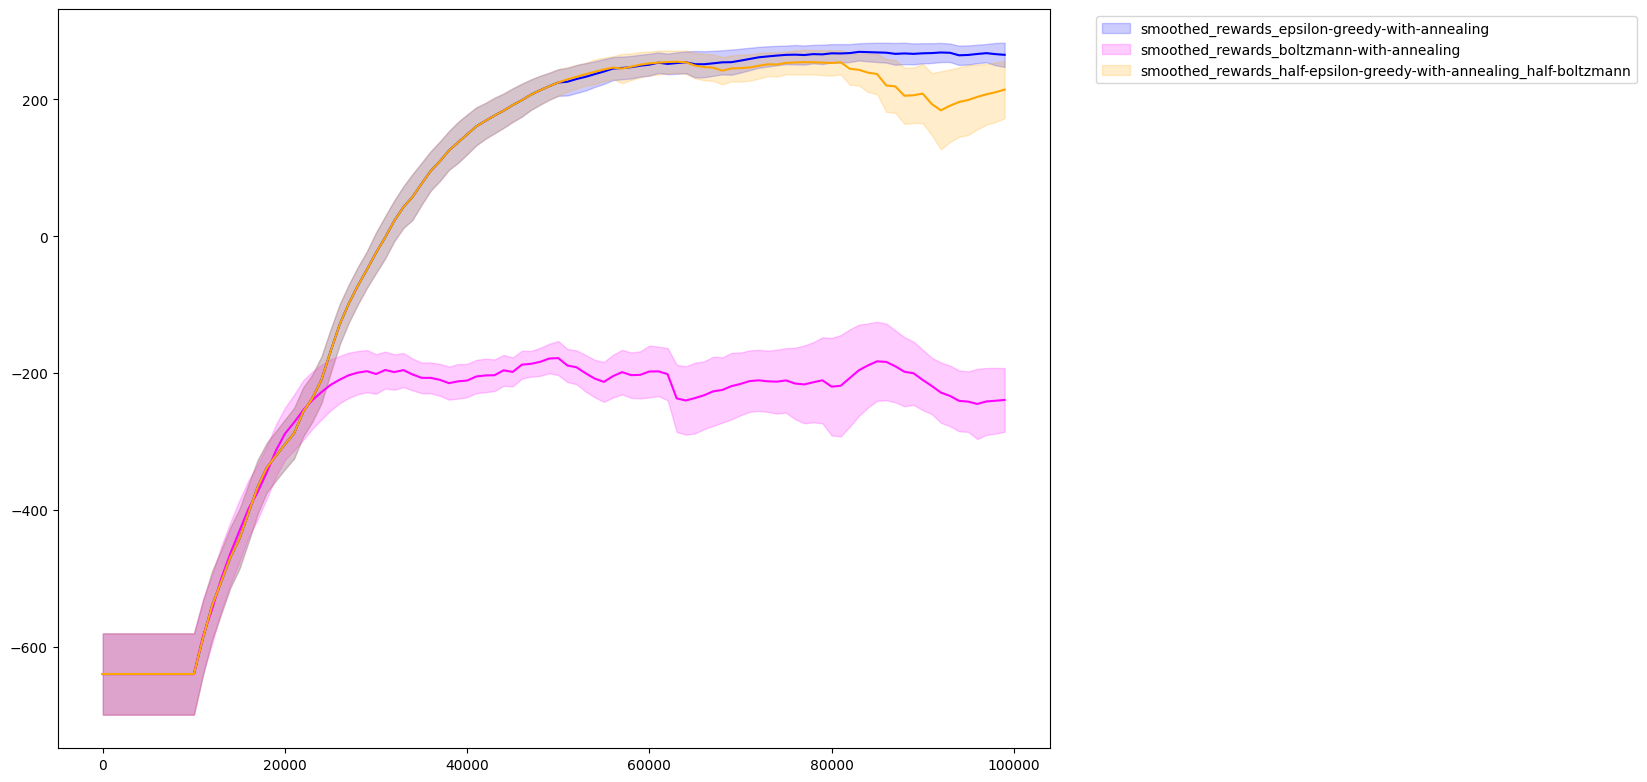

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_by_ids([2, 4, 7])

## Investigetion

### investigate()

In [ ]:
def investigate(class_agent, prefix, hyperparameters, means=None, stds=None):
  result_means_many = [] # TODO: check
  result_stds_many = [] # TODO: check
  if means is not None:
    result_means_many.append(means)
  if stds is not None:
    result_stds_many.append(stds)

  names_list = []
  if means is not None:
    names_list.append(prefix + " default setting")
  colours_list = ["red", "green", "blue",
           "yellow", "magenta",
           "cyan", "black",
           "orange"]

  for dict_p in hyperparameters: # TODO: check
    params_str = ", ".join([f"{k}={v}" for k, v in dict_p.items()])
    names_list.append(f"{prefix} {params_str}")

    model = class_agent(args, **dict_p) # TODO: check
    result_means, result_stds = train_dqn(model)
    result_means_many.append(result_means)
    result_stds_many.append(result_stds)

  plot_results_many(result_means_many, result_stds_many, names_list, colours_list[:len(names_list)]) # TODO: check
  return result_means_many, result_stds_many

### investigate_half()

In [ ]:
def investigate_half(class_agent_1, class_agent_2, prefix, switch_ratios, hyperparameters, means=None, stds=None):
  result_means_many = [] # TODO: check
  result_stds_many = [] # TODO: check
  if means is not None:
    result_means_many.append(means)
  if stds is not None:
    result_stds_many.append(stds)

  assert len(switch_ratios) == len(hyperparameters), f"switch_ratios length ({len(switch_ratios)}) must be the same as hyperparameters length ({len(hyperparameters)})"

  names_list = []
  colours_list = ["red", "green", "blue",
           "yellow", "magenta",
           "cyan", "black",
           "orange"]

  first_half_training_args = parse_args()
  second_half_training_args = parse_args()
  second_half_training_args.init_steps = 1

  n_training_steps_list = []
  n_training_steps = first_half_training_args.n_training_steps
  for ratio in switch_ratios:
    assert type(ratio) == float and ratio >= 0 and ratio <= 1, f"ratio must be a float number from [0, 1]"
    n_training_steps_list.append(int(n_training_steps * ratio))

  i = 0
  for dict_1, dict_2 in hyperparameters: # TODO: check
    params_str = ", ".join([f"{k}={v} " for k, v in dict_1.items()]).join([f"{k}={v} " for k, v in dict_2.items()])
    names_list.append(f"{prefix} {params_str}")

    first_half_training_args.n_training_steps = n_training_steps_list[i]
    second_half_training_args.n_training_steps = n_training_steps - n_training_steps_list[i]

    model_1 = class_agent_1(first_half_training_args, **dict_1) # TODO: check
    model_2 = class_agent_2(second_half_training_args, **dict_2) # TODO: check

    result_means, result_stds = train_two_halfs_dqn(model_1, model_2)
    result_means_many.append(result_means)
    result_stds_many.append(result_stds)
    i += 1

  plot_results_many(result_means_many, result_stds_many, names_list, colours_list[:len(hyperparameters)]) # TODO: check
  return result_means_many, result_stds_many

### EpsilonGreedy

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -163.73120302683486; eval_std: 52.89282064514079
Training step: 12000
Eval mean: -26.228323469255006;

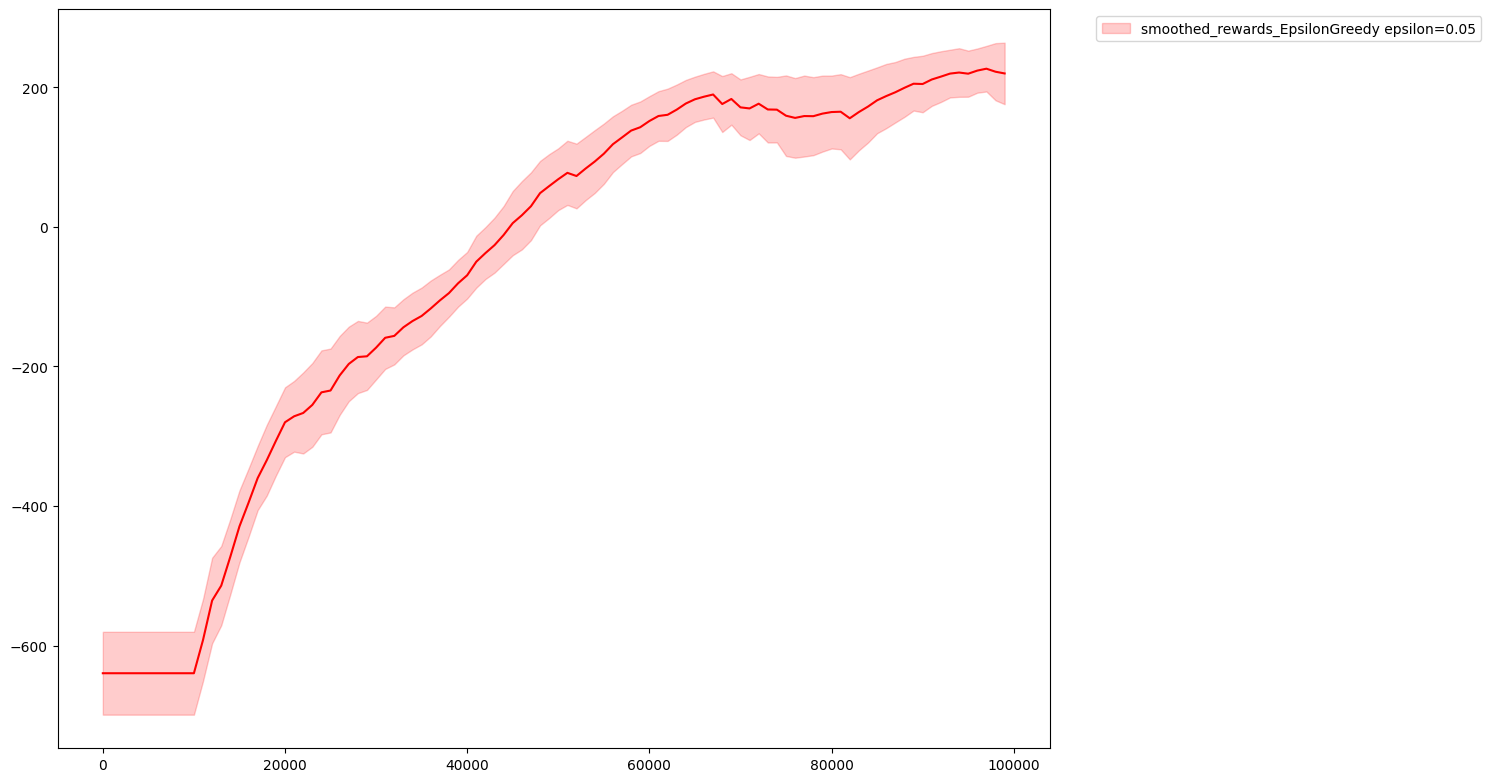

<Figure size 640x480 with 0 Axes>

In [ ]:
# hyperparameters = [
#     { 'epsilon': 0.05 }
# ]
# results_means_epsilon_greedy_dqn_many, results_stds_epsilon_greedy_dqn_many = investigate(
#     EpsilonGreedyDQN,
#     "EpsilonGreedy",
#     hyperparameters
#     )

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/results_means_epsilon_greedy_dqn_many.npy', results_means_epsilon_greedy_dqn_many)
# np.save('/content/drive/MyDrive/hw4_data/results_stds_epsilon_greedy_dqn_many.npy', results_stds_epsilon_greedy_dqn_many)

In [ ]:
# hyperparameters = [
#     { 'epsilon': 0.05 },
#     { 'epsilon': 0.3 },
# ]
# results_means_epsilon_greedy_dqn_many, results_stds_epsilon_greedy_dqn_many = investigate(
#     EpsilonGreedyDQN,
#     "EpsilonGreedy",
#     hyperparameters,
#     result_means_epsilon_greedy_dqn,
#     result_stds_epsilon_greedy_dqn
#     )

### EpsilonGreedyWithAnnealing

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -89.91165489911411; eval_std: 7.888205319952004
Training step: 12000
Eval mean: -72.36041779575692; e

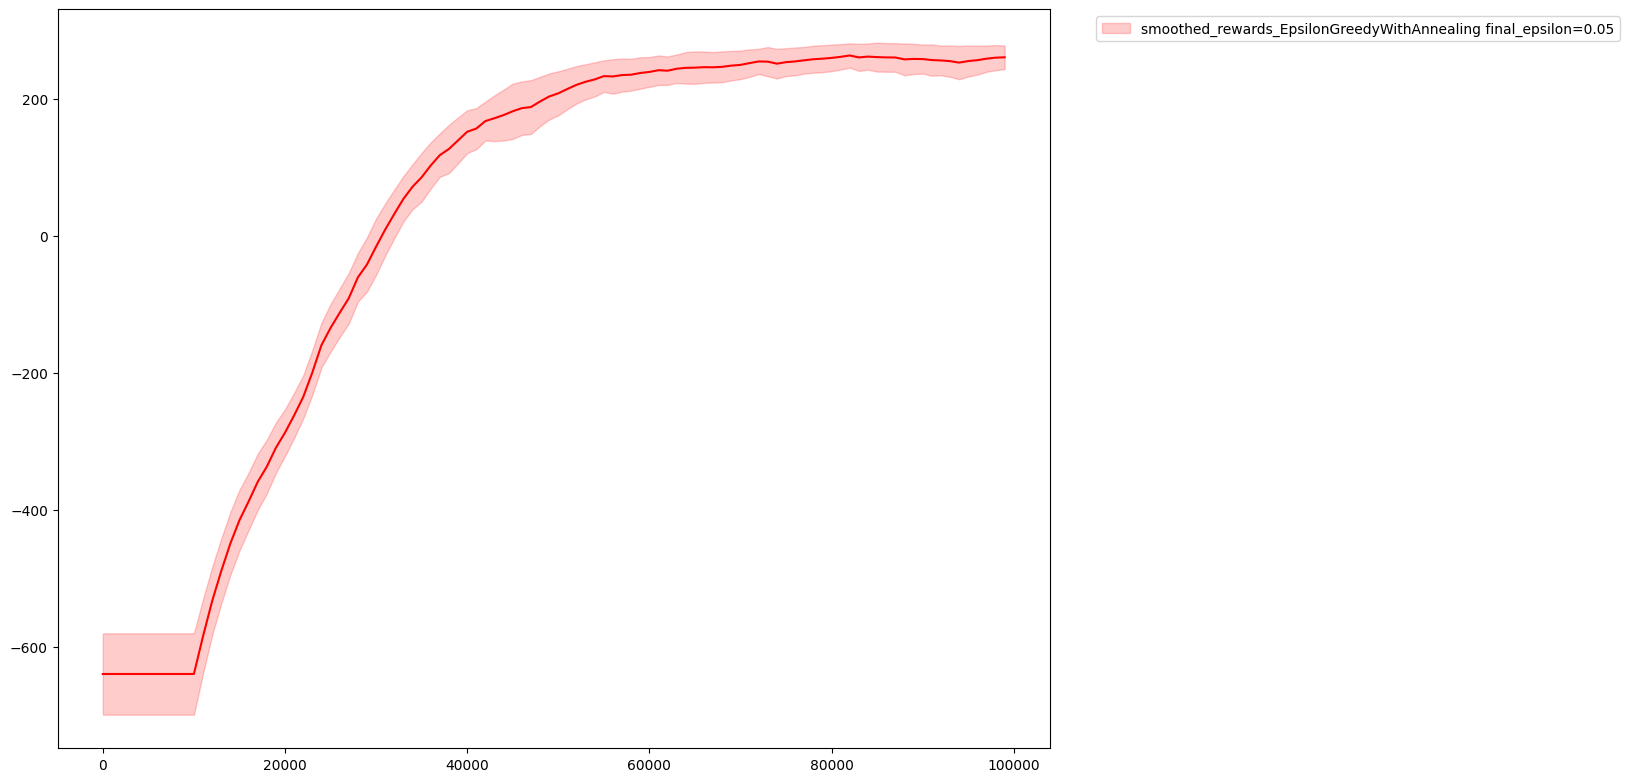

<Figure size 640x480 with 0 Axes>

In [ ]:
# hyperparameters = [
#     { 'final_epsilon': 0.05 }
# ]
# results_means_epsilon_greedy_with_annealing_dqn_many, results_stds_epsilon_greedy_with_annealing_dqn_many = investigate(
#     EpsilonGreedyWithAnnealingDQN,
#     "EpsilonGreedyWithAnnealing",
#     hyperparameters
# )

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/results_means_epsilon_greedy_with_annealing_dqn_many.npy', results_means_epsilon_greedy_with_annealing_dqn_many)
# np.save('/content/drive/MyDrive/hw4_data/results_stds_epsilon_greedy_with_annealing_dqn_many.npy', results_stds_epsilon_greedy_with_annealing_dqn_many)

In [ ]:
# hyperparameters = [
#     { 'final_epsilon': 0.05 },
#     { 'final_epsilon': 0.2 },
# ]
# results_means_epsilon_greedy_with_annealing_dqn_many, results_stds_epsilon_greedy_with_annealing_dqn_many = investigate(
#     EpsilonGreedyWithAnnealingDQN,
#     "EpsilonGreedyWithAnnealing",
#     hyperparameters,
#     result_means_epsilon_greedy_with_annealing_dqn,
#     result_stds_epsilon_greedy_with_annealing_dqn
# )

### Boltzmann

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -46.55560035560336; eval_std: 36.80632498214944
Training step: 12000
Eval mean: -66.89866812823597; e

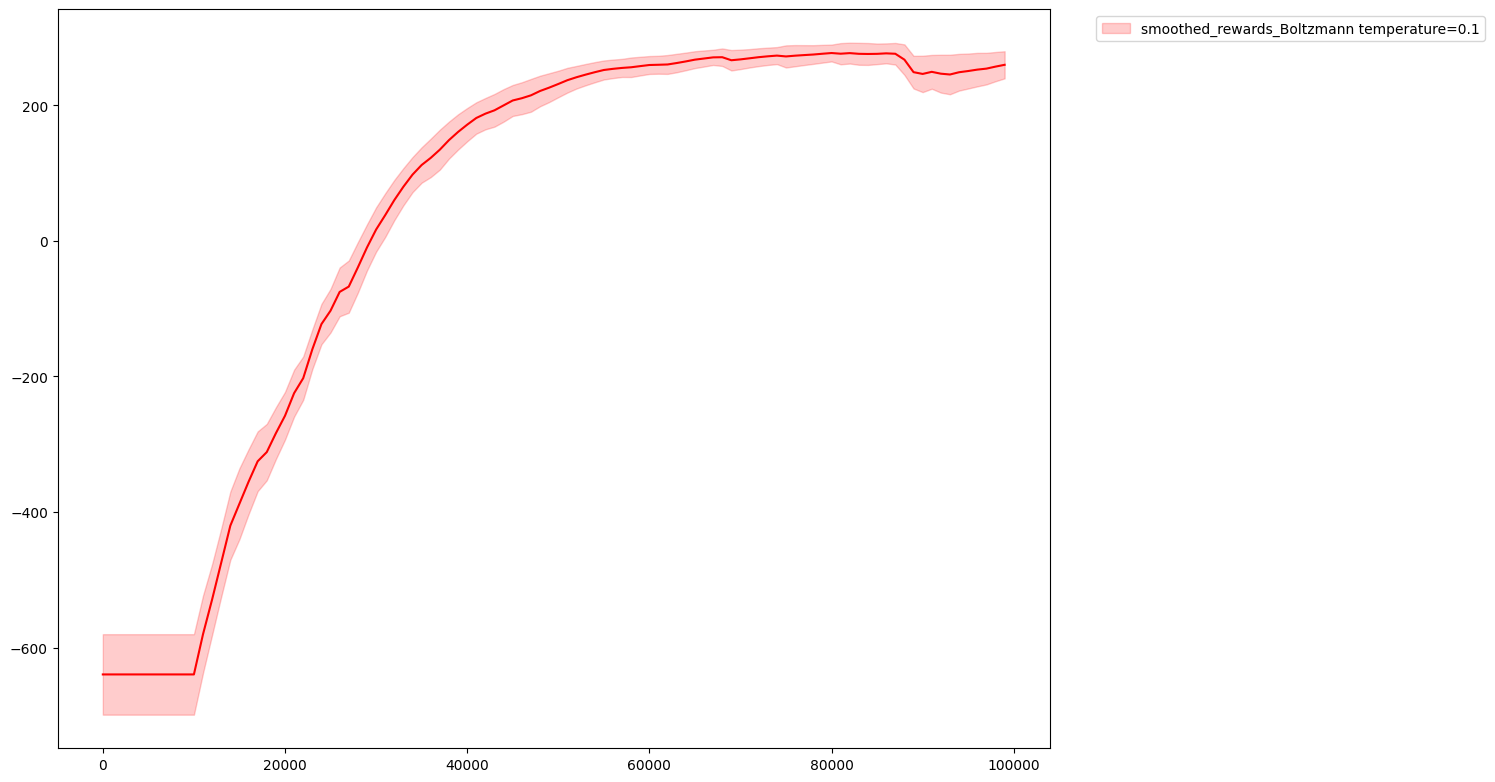

<Figure size 640x480 with 0 Axes>

In [ ]:
# hyperparameters = [
#     { 'temperature': 0.1 }
# ]
# results_means_boltzmann_dqn_many, results_stds_boltzmann_dqn_many = investigate(
#     BoltzmannDQN,
#     "Boltzmann",
#     hyperparameters
# )

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/results_means_boltzmann_dqn_many.npy', results_means_boltzmann_dqn_many)
# np.save('/content/drive/MyDrive/hw4_data/results_stds_boltzmann_dqn_many.npy', results_stds_boltzmann_dqn_many)

In [ ]:
# hyperparameters = [
#     { 'temperature': 0.1 },
#     { 'temperature': 5.0 },
# ]
# results_means_boltzmann_dqn_many, results_stds_boltzmann_dqn_many = investigate(
#     BoltzmannDQN,
#     "Boltzmann",
#     hyperparameters,
#     result_means_boltzmann_dqn,
#     result_stds_boltzmann_dqn
# )

### MaxBoltzmann

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -174.97577797201657; eval_std: 26.537119466984702
Training step: 12000
Eval mean: 61.086785415659484;

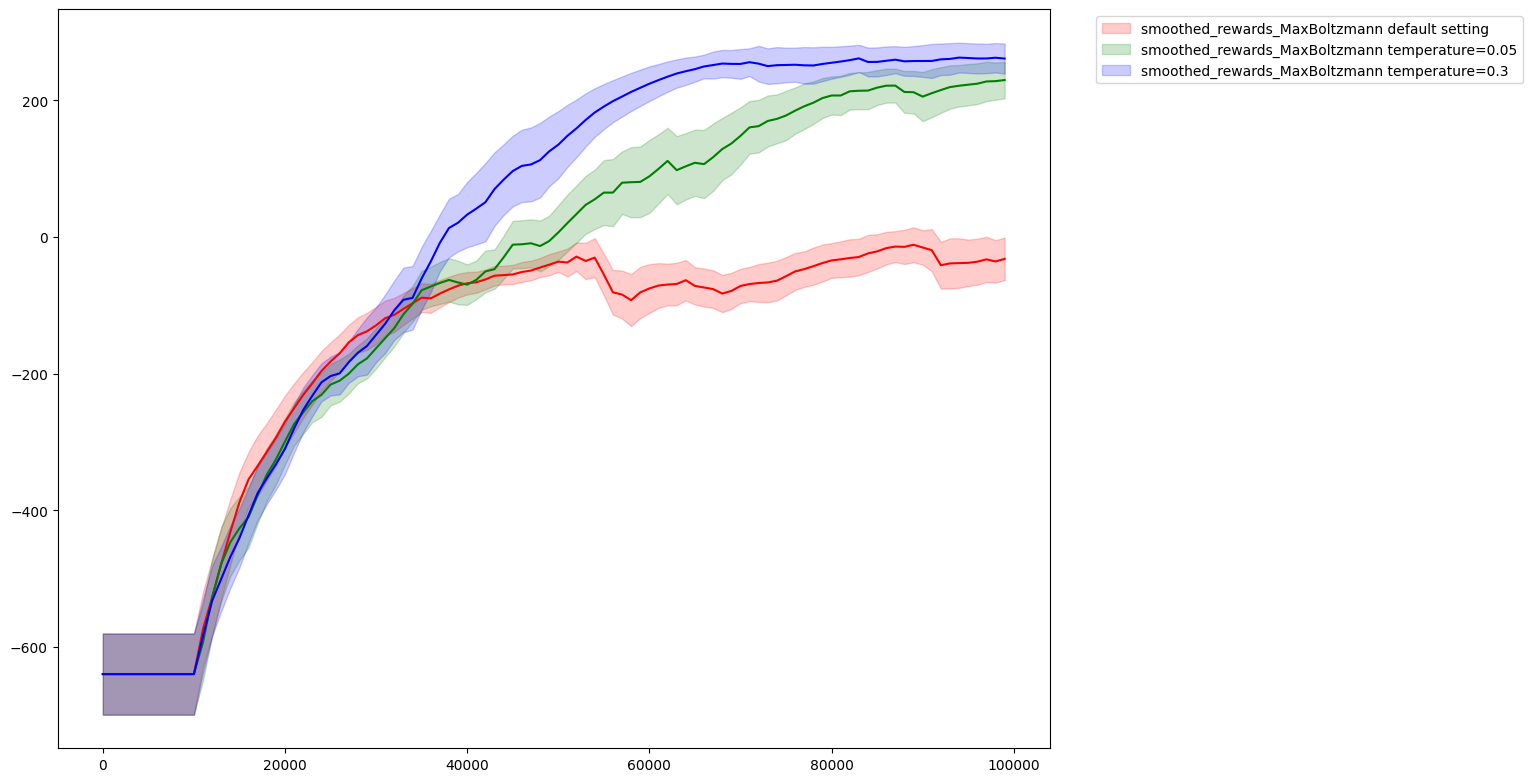

<Figure size 640x480 with 0 Axes>

In [ ]:
# hyperparameters = [
#     { 'temperature': 0.05 },
#     { 'temperature': 0.3 },
# ]
# results_means_max_boltzmann_dqn_many, results_stds_max_boltzmann_dqn_many = investigate(
#     MaxBoltzmannDQN,
#     "MaxBoltzmann",
#     hyperparameters,
#     result_means_max_boltzmann_dqn,
#     result_stds_max_boltzmann_dqn
# )

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/results_means_max_boltzmann_dqn_many.npy', results_means_max_boltzmann_dqn_many)
# np.save('/content/drive/MyDrive/hw4_data/results_stds_max_boltzmann_dqn_many.npy', results_stds_max_boltzmann_dqn_many)

### MaxBoltzmannWithTemperatureAnnealing

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -97.68125916811412; eval_std: 7.663729227125282
Training step: 12000
Eval mean: -88.76707000160998; e

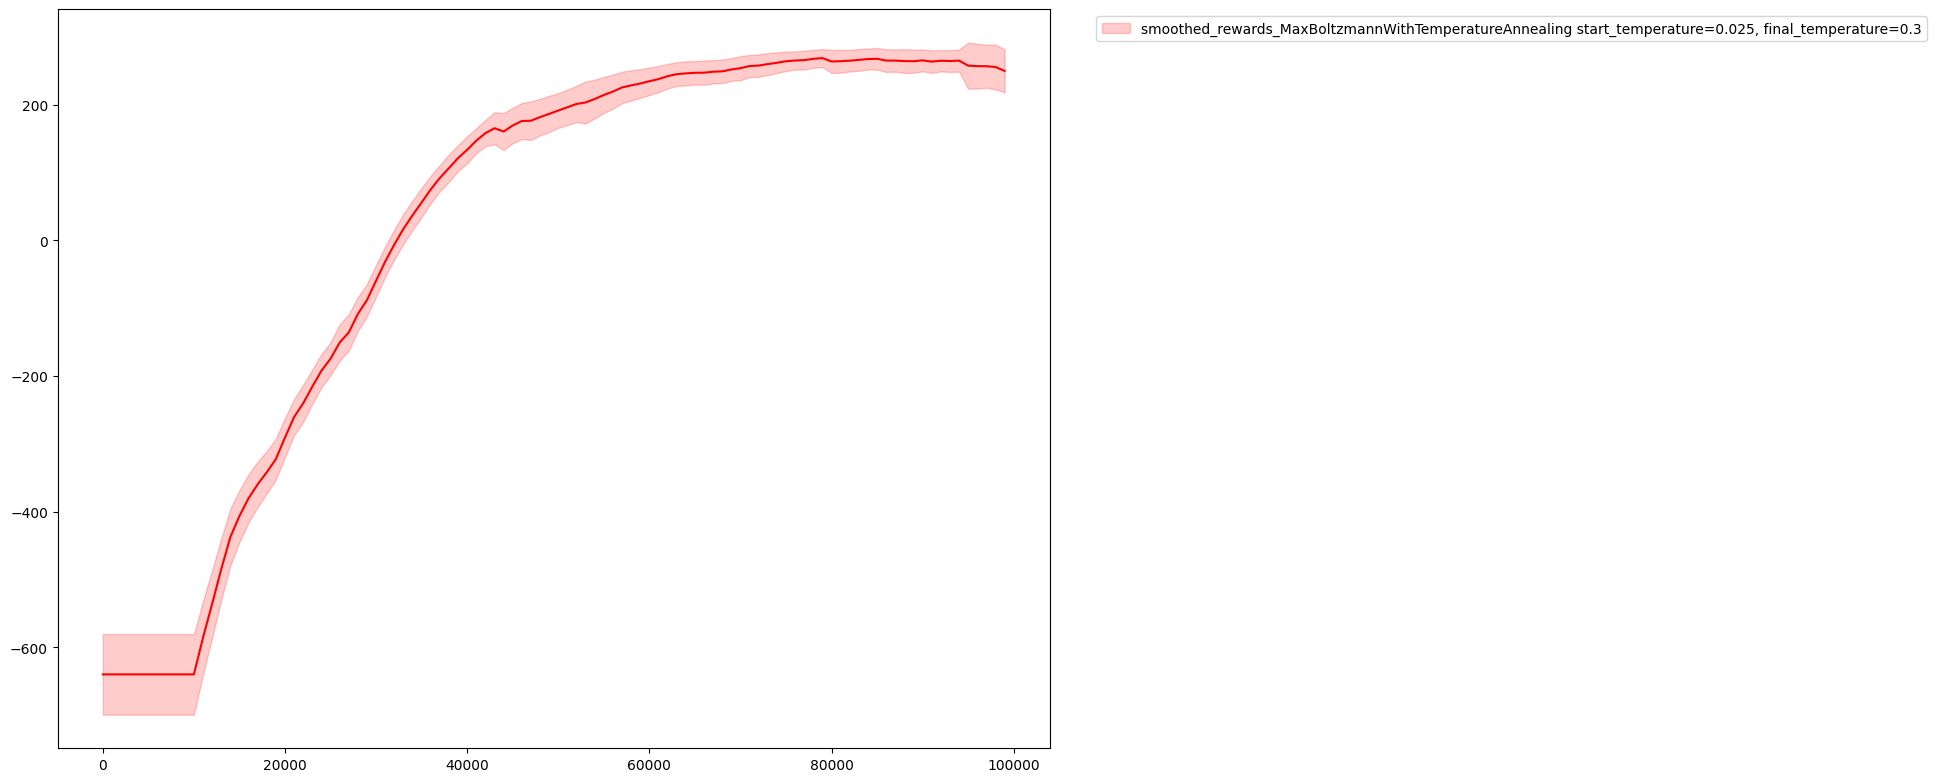

<Figure size 640x480 with 0 Axes>

In [ ]:
# hyperparameters = [
#     { 'start_temperature': 0.025, 'final_temperature': 0.3 }
# ]
# results_means_max_boltzmann_temp_anneal_dqn_many, results_stds_max_boltzmann_temp_anneal_dqn_many = investigate(
#     MaxBoltzmannWithTemperatureAnnealingDQN,
#     "MaxBoltzmannWithTemperatureAnnealing",
#     hyperparameters
# )

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: 18.79586443043499; eval_std: 48.18257794414795
Training step: 12000
Eval mean: 25.076112882432056; ev

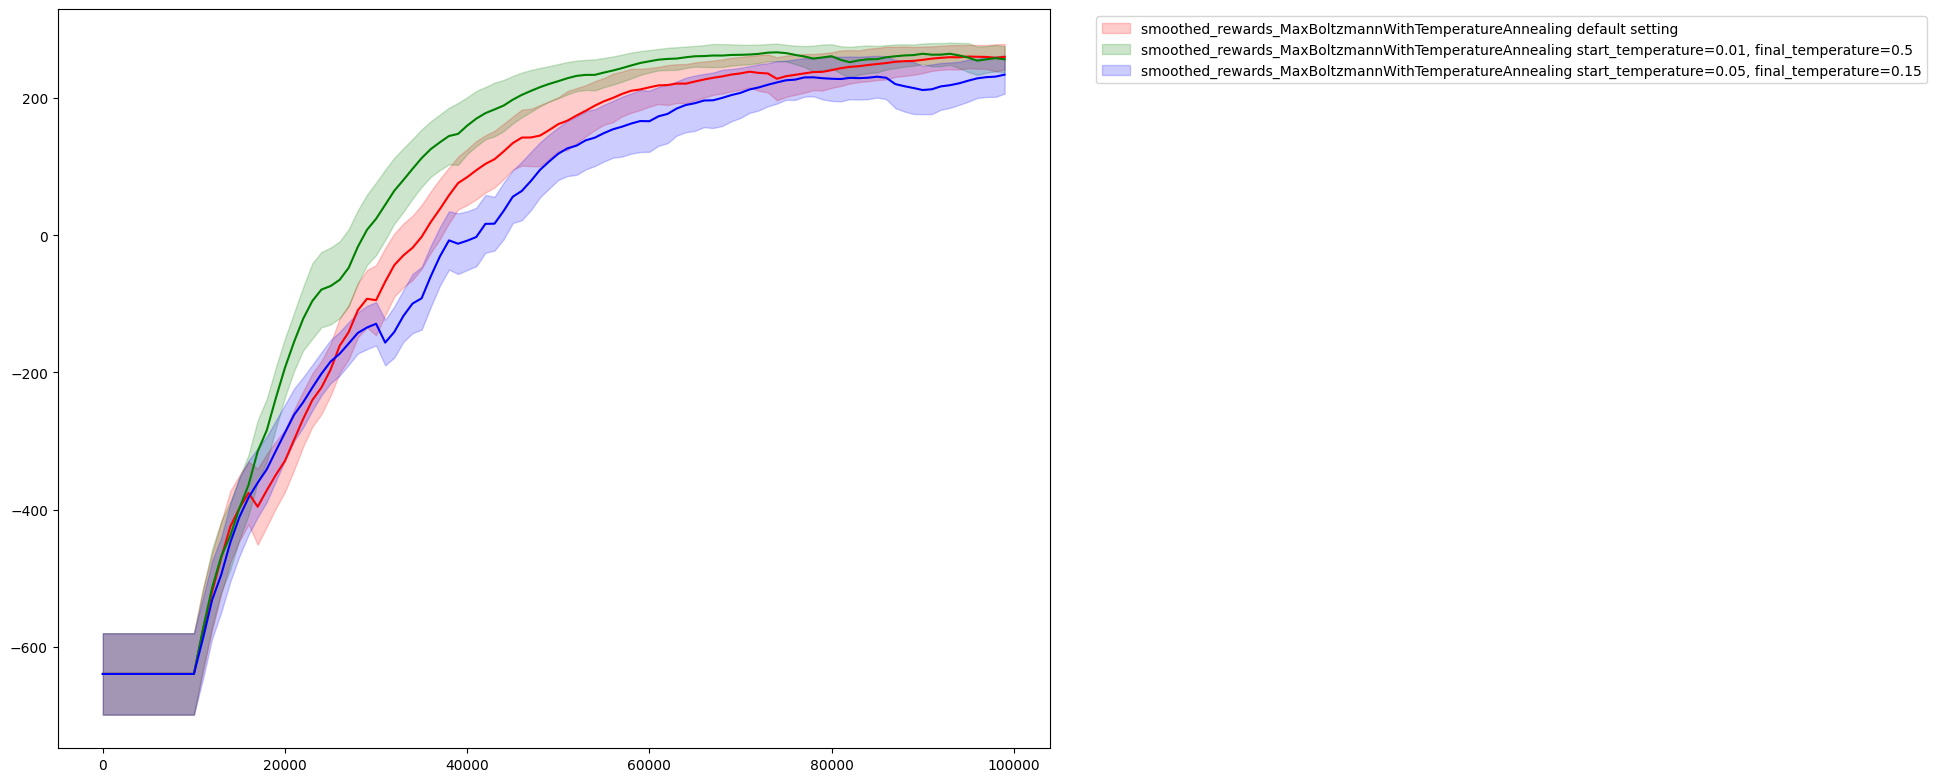

<Figure size 640x480 with 0 Axes>

In [ ]:
# hyperparameters = [
#     { 'start_temperature': 0.01, 'final_temperature': 0.5 },
#     { 'start_temperature': 0.05, 'final_temperature': 0.15 },
# ]
# results_means_max_boltzmann_temp_anneal_dqn_many, results_stds_max_boltzmann_temp_anneal_dqn_many = investigate(
#     MaxBoltzmannWithTemperatureAnnealingDQN,
#     "MaxBoltzmannWithTemperatureAnnealing",
#     hyperparameters,
#     result_means_max_boltzmann_temp_anneal_dqn,
#     result_stds_max_boltzmann_temp_anneal_dqn
# )

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/results_means_max_boltzmann_temp_anneal_dqn_many.npy', results_means_max_boltzmann_temp_anneal_dqn_many)
# np.save('/content/drive/MyDrive/hw4_data/results_stds_max_boltzmann_temp_anneal_dqn_many.npy', results_stds_max_boltzmann_temp_anneal_dqn_many)

### BoltzmannWithTemperatureAnnealing

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -68.27517034890576; eval_std: 6.917837302954383
Training step: 12000
Eval mean: -121.66250012138737; 

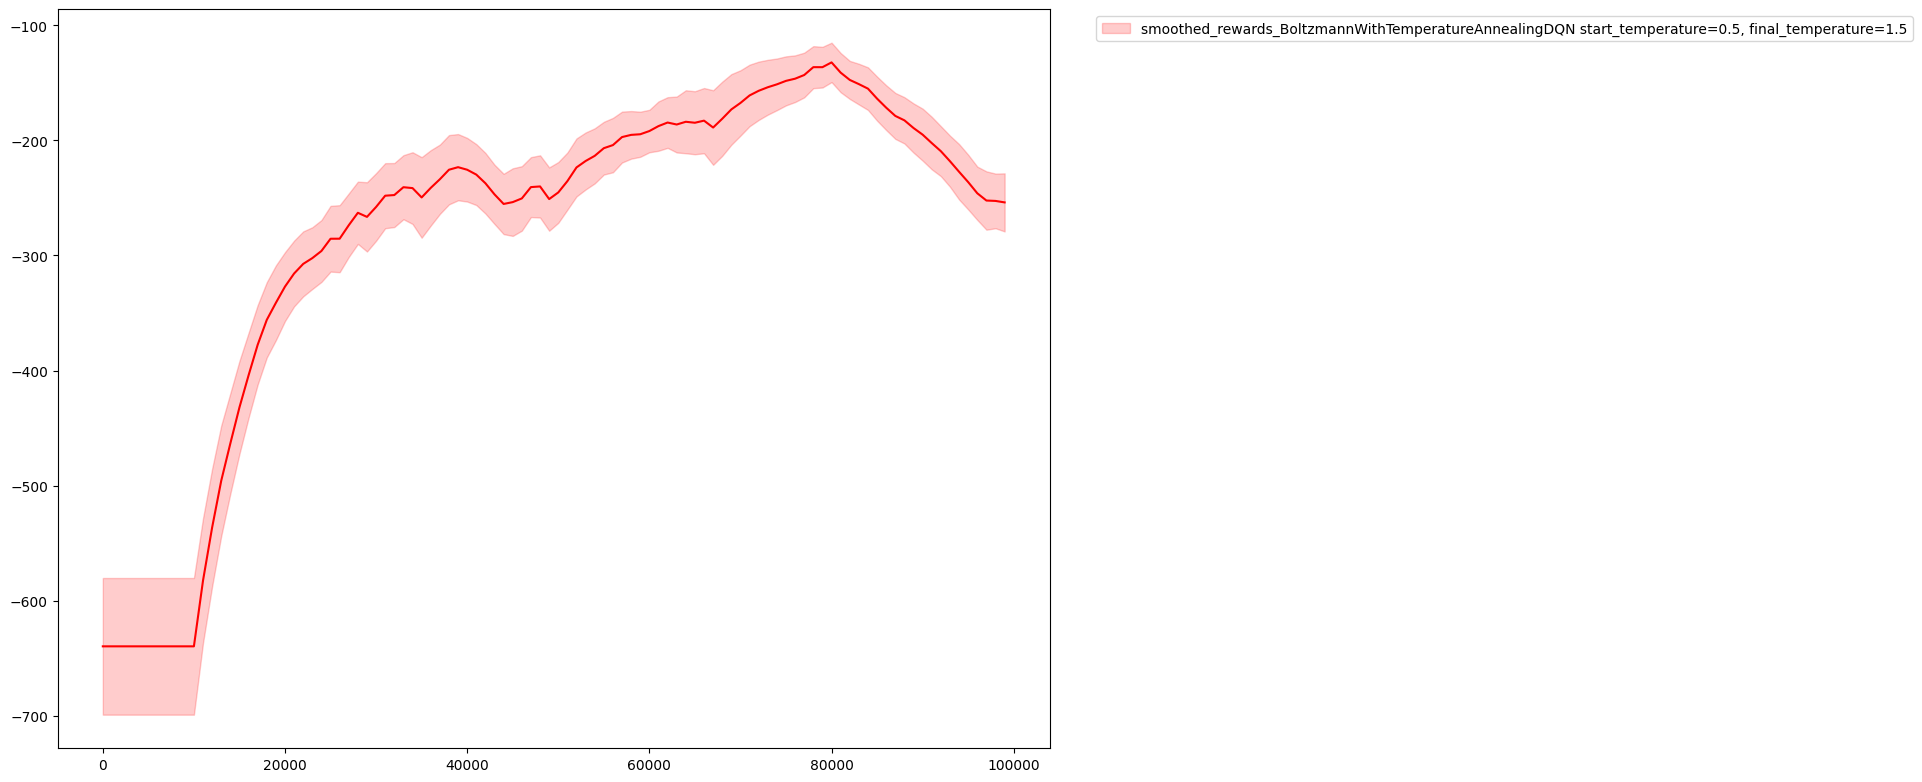

<Figure size 640x480 with 0 Axes>

In [ ]:
# hyperparameters = [
#     { 'start_temperature': 0.5, 'final_temperature': 1.5 }
# ]
# results_means_boltzmann_temp_anneal_dqn_many, results_stds_boltzmann_temp_anneal_dqn_many = investigate(
#     BoltzmannWithTemperatureAnnealingDQN,
#     "BoltzmannWithTemperatureAnnealingDQN",
#     hyperparameters
# )

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -76.79610875233402; eval_std: 7.633369098923837
Training step: 12000
Eval mean: -150.76225047424103; 

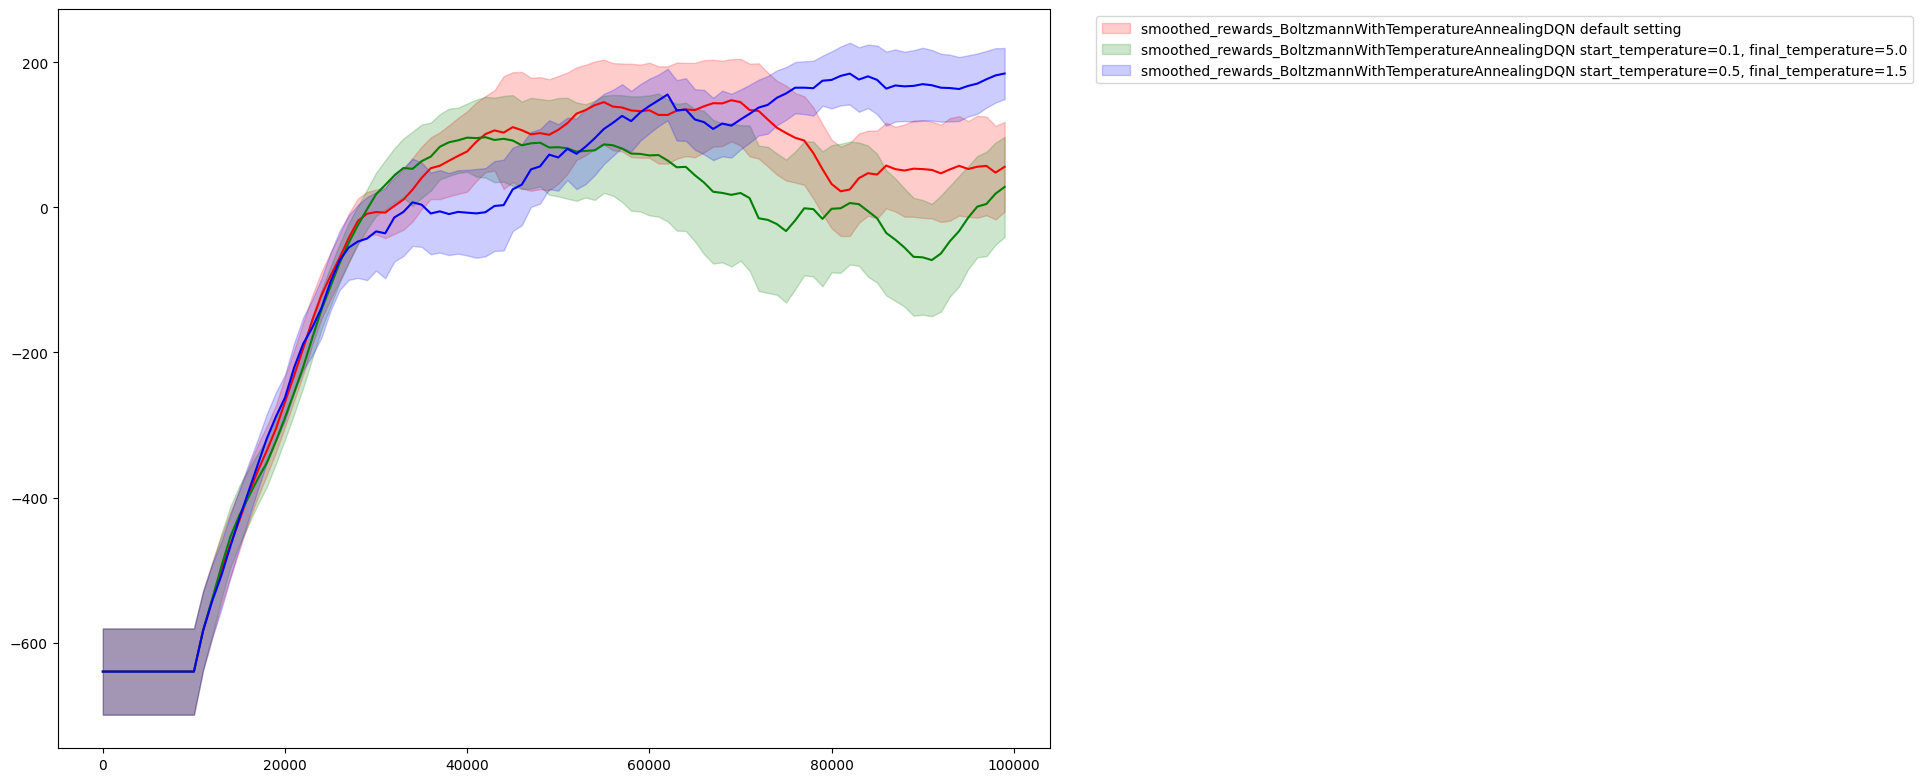

<Figure size 640x480 with 0 Axes>

In [ ]:
# hyperparameters = [
#     { 'start_temperature': 0.1, 'final_temperature': 5.0 },
#     { 'start_temperature': 0.5, 'final_temperature': 1.5 },
# ]
# results_means_boltzmann_temp_anneal_dqn_many, results_stds_boltzmann_temp_anneal_dqn_many = investigate(
#     BoltzmannWithTemperatureAnnealingDQN,
#     "BoltzmannWithTemperatureAnnealingDQN",
#     hyperparameters,
#     result_means_boltzmann_temp_anneal_dqn,
#     result_stds_boltzmann_temp_anneal_dqn
# )

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/results_means_boltzmann_temp_anneal_dqn_many.npy', results_means_boltzmann_temp_anneal_dqn_many)
# np.save('/content/drive/MyDrive/hw4_data/results_stds_boltzmann_temp_anneal_dqn_many.npy', results_stds_boltzmann_temp_anneal_dqn_many)

### Two halves

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -114.15075930943605; eval_std: 8.98149810557351
Training step: 12000
Eval mean: -108.27444985464808; 

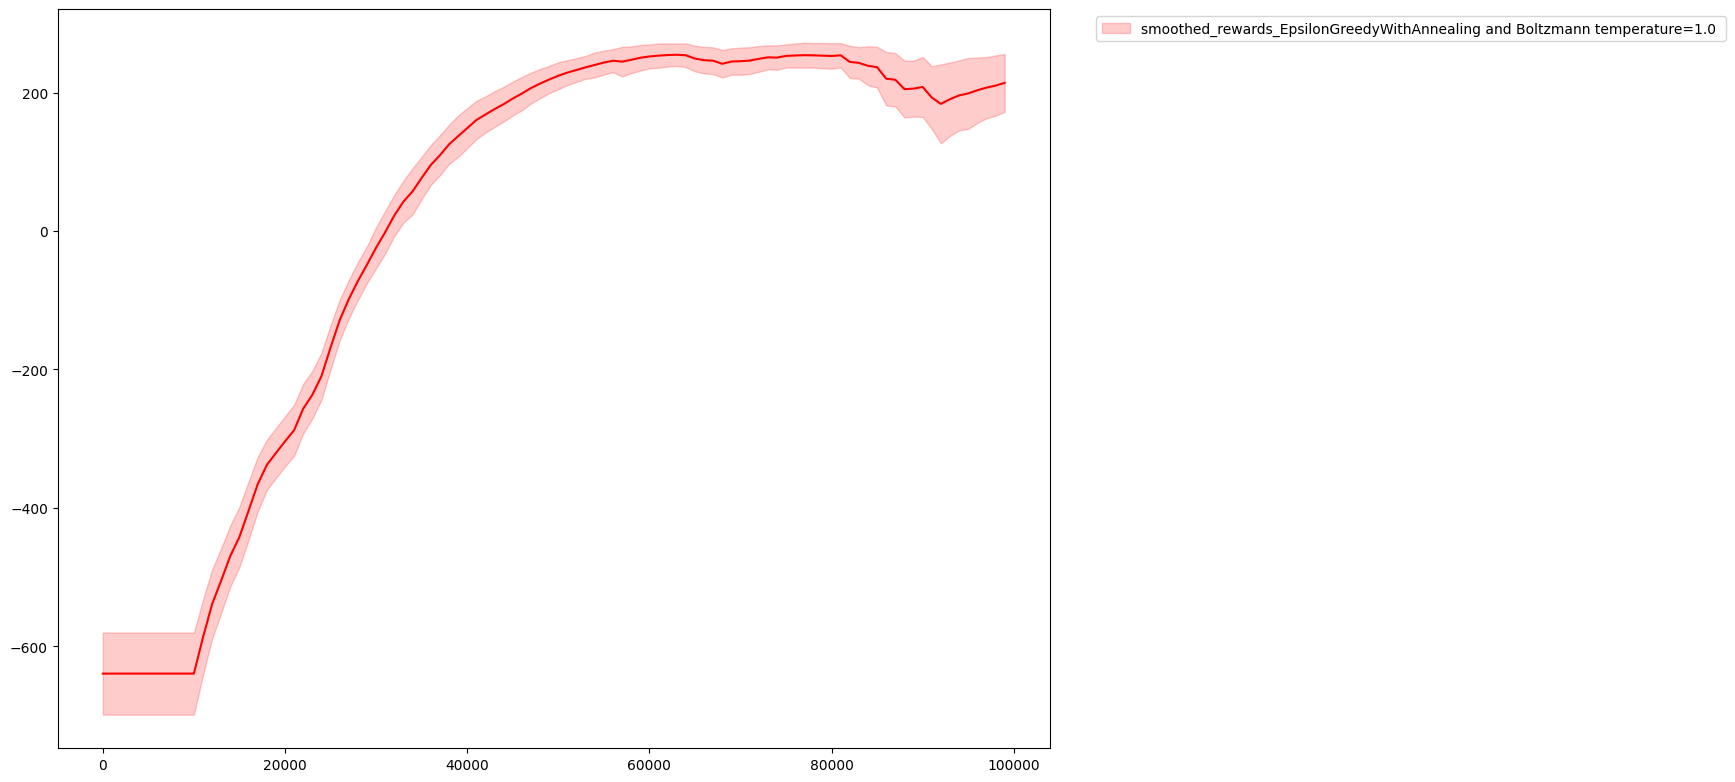

<Figure size 640x480 with 0 Axes>

In [ ]:
# hyperparameters = [
#     ( { 'final_epsilon': 0.1 }, { 'temperature': 1.0 })
# ]
# switch_ratios = [
#     0.5
# ]
# results_means_two_halves_dqn_many, results_stds_two_halves_dqn_many = investigate_half(
#     EpsilonGreedyWithAnnealingDQN,
#     BoltzmannDQN,
#     "EpsilonGreedyWithAnnealing and Boltzmann",
#     switch_ratios,
#     hyperparameters
# )

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/results_means_two_halves_dqn_many.npy', results_means_two_halves_dqn_many)
# np.save('/content/drive/MyDrive/hw4_data/results_stds_two_halves_dqn_many.npy', results_stds_two_halves_dqn_many)

In [ ]:
# hyperparameters = [
#     ( { 'final_epsilon': 0.05 }, { 'temperature': 2.0 }),
#     ( { 'final_epsilon': 0.2 }, { 'temperature': 0.5 })
# ]
# switch_ratios = [
#     0.5,
#     0.5
# ]
# results_means_two_halves_dqn_many, results_stds_two_halves_dqn_many = investigate_half(
#     EpsilonGreedyWithAnnealingDQN,
#     BoltzmannDQN,
#     "EpsilonGreedyWithAnnealing and Boltzmann",
#     switch_ratios,
#     hyperparameters,
#     result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn,
#     result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn
# )

### SoftSwitch

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -98.0207964744576; eval_std: 45.72288575126702
Training step: 12000
Eval mean: -209.75590672896183; e

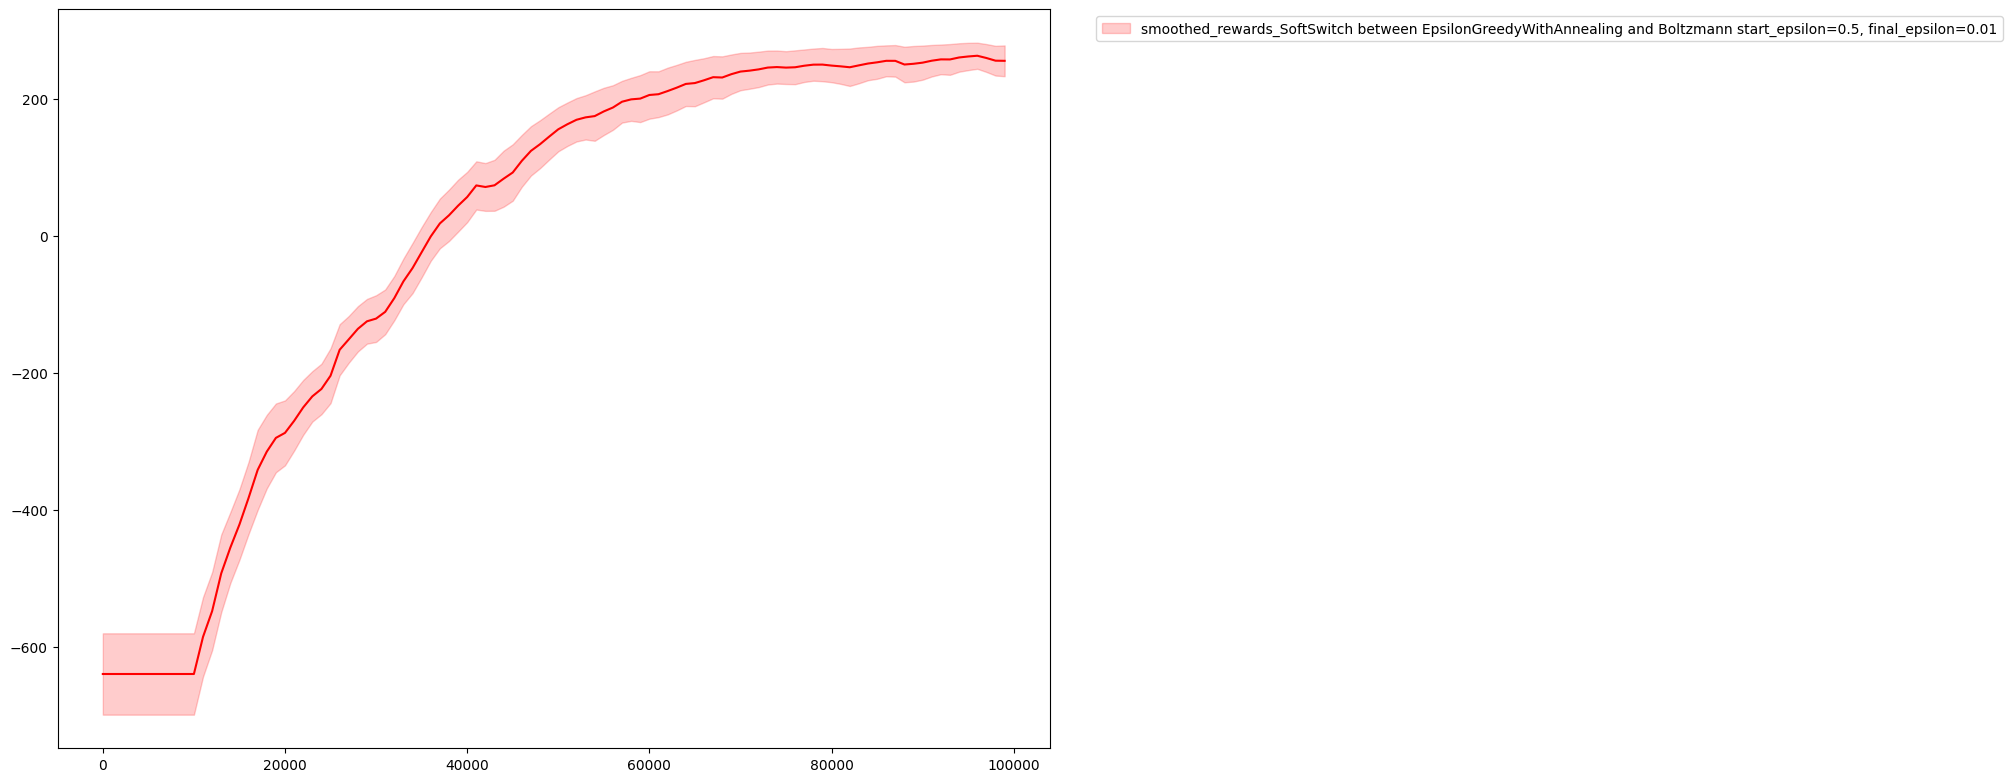

<Figure size 640x480 with 0 Axes>

In [ ]:
# # TODO: comment
# hyperparameters = [
#     {'start_epsilon': 0.5, 'final_epsilon': 0.01}
# ]
# results_means_soft_switch_dqn_many, results_stds_soft_switch_dqn_many = investigate(
#     class_agent=SoftSwitchDQN,
#     prefix="SoftSwitch between EpsilonGreedyWithAnnealing and Boltzmann",
#     hyperparameters=hyperparameters
# )

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: 65.5761768065488; eval_std: 27.85293328095597
Training step: 12000
Eval mean: 103.39843077582852; eva

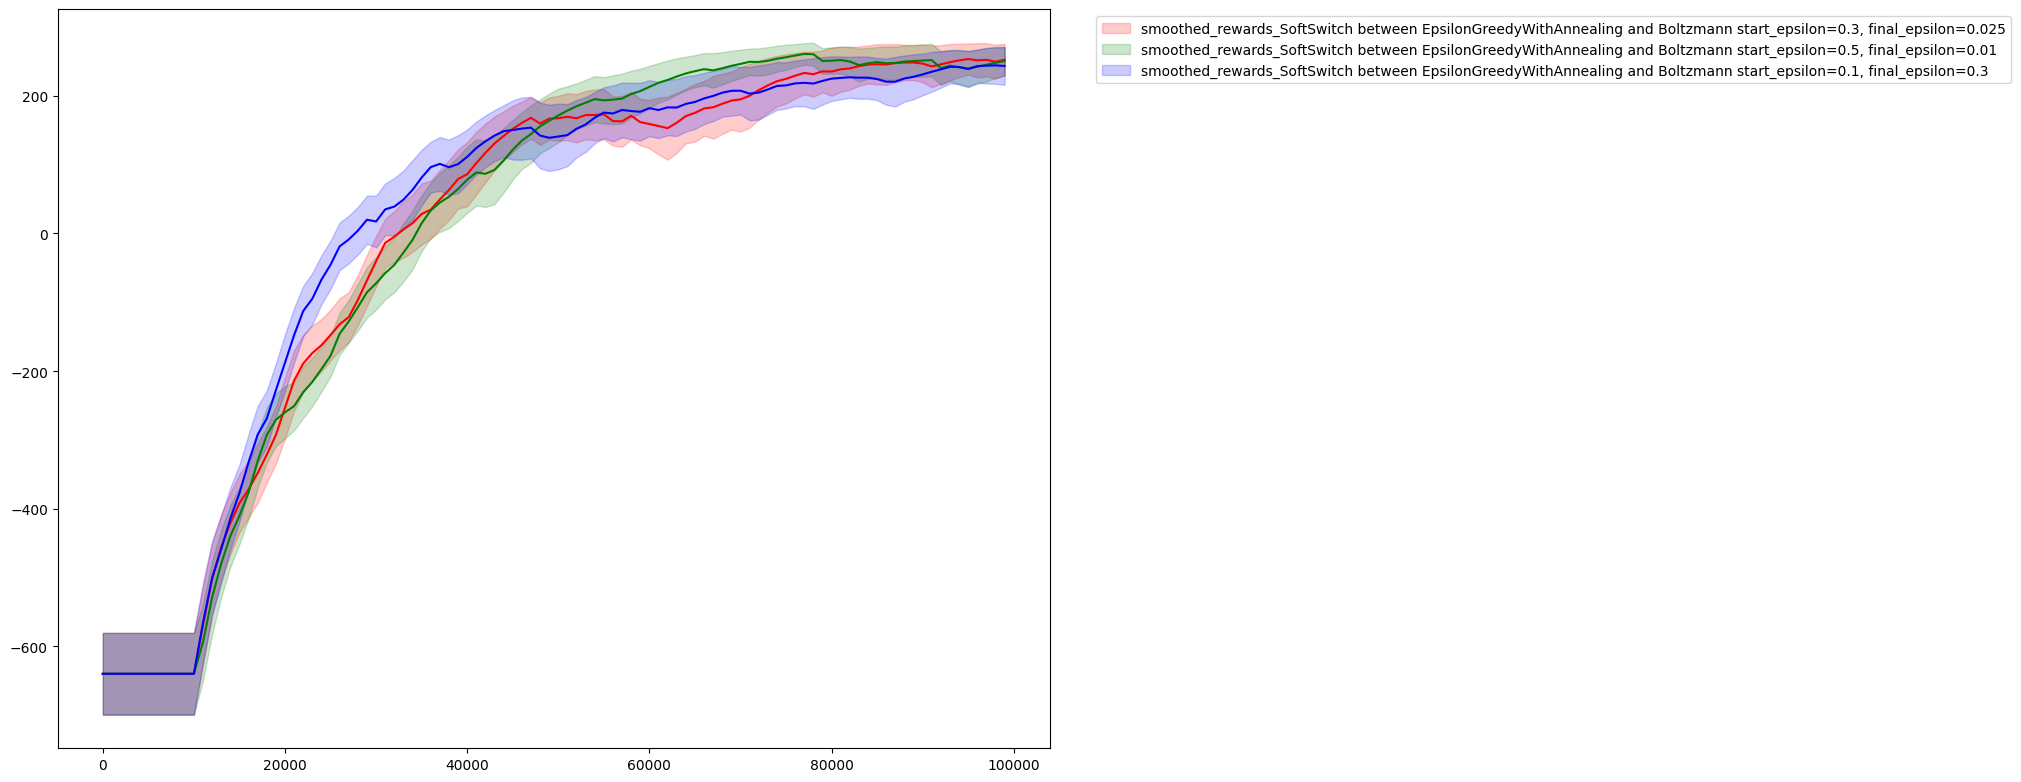

<Figure size 640x480 with 0 Axes>

In [ ]:
# # TODO: comment
# hyperparameters = [
#     {'start_epsilon': 0.3, 'final_epsilon': 0.025},
#     {'start_epsilon': 0.5, 'final_epsilon': 0.01},
#     {'start_epsilon': 0.1, 'final_epsilon': 0.3},
# ]
# results_means_soft_switch_dqn_many, results_stds_soft_switch_dqn_many = investigate(
#     class_agent=SoftSwitchDQN,
#     prefix="SoftSwitch between EpsilonGreedyWithAnnealing and Boltzmann",
#     hyperparameters=hyperparameters
# )

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/results_means_soft_switch_dqn_many.npy', results_means_soft_switch_dqn_many)
# np.save('/content/drive/MyDrive/hw4_data/results_stds_soft_switch_dqn_many.npy', results_stds_soft_switch_dqn_many)

### BoltzmannWithExponentialTemperatureAnnealing

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -52.949554761644585; eval_std: 12.401267077898426
Training step: 12000
Eval mean: -129.41858876629195

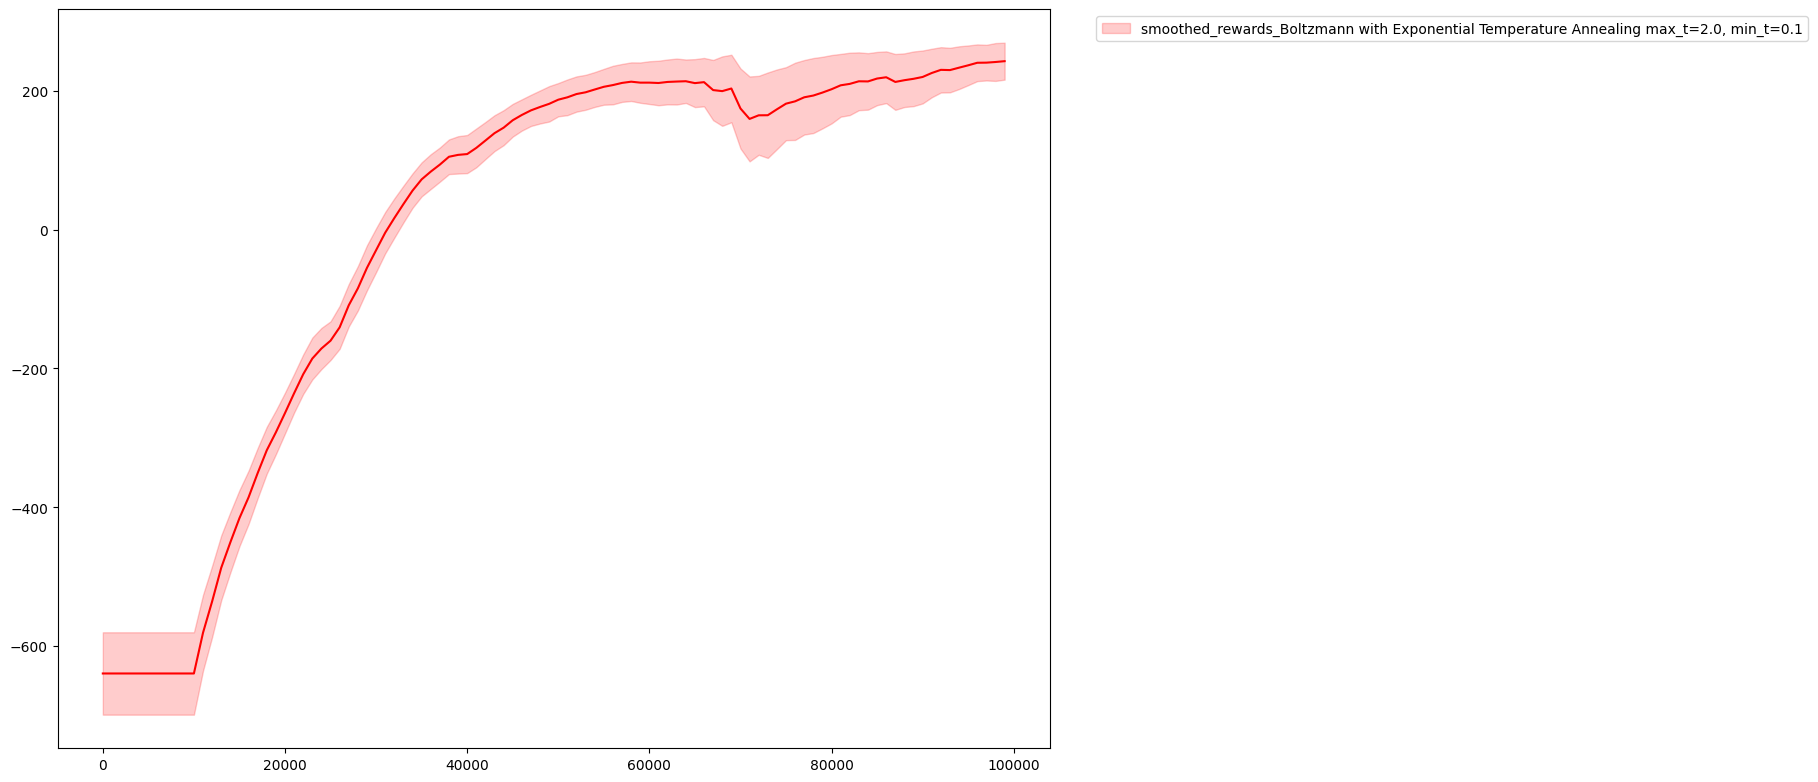

<Figure size 640x480 with 0 Axes>

In [ ]:
# hyperparameters = [
#     {'max_t': 2.0, 'min_t': 0.1}
# ]
# results_means_boltzmann_exp_temp_anneal_dqn_many, results_stds_boltzmann_exp_temp_anneal_dqn_many = investigate(
#     BoltzmannWithExponentialTemperatureAnnealingDQN,
#     "Boltzmann with Exponential Temperature Annealing",
#     hyperparameters
# )

In [ ]:
# np.save('/content/drive/MyDrive/hw4_data/results_means_boltzmann_exp_temp_anneal_dqn_many.npy', results_means_boltzmann_exp_temp_anneal_dqn_many)
# np.save('/content/drive/MyDrive/hw4_data/results_stds_boltzmann_exp_temp_anneal_dqn_many.npy', results_stds_boltzmann_exp_temp_anneal_dqn_many)

In [ ]:
# hyperparameters = [
#     {'max_t': 2.0, 'min_t': 0.1},
#     {'max_t': 4.0, 'min_t': 0.05},
#     {'max_t': 1.0, 'min_t': 0.2},
# ]
# results_means_boltzmann_exp_temp_anneal_dqn_many, results_stds_boltzmann_exp_temp_anneal_dqn_many = investigate(
#     BoltzmannWithExponentialTemperatureAnnealingDQN,
#     "Boltzmann with Exponential Temperature Annealing",
#     hyperparameters
# )

## Models' with tuned hyperparameters comparision


The best:

* Epsilon-Greedy: 0.05 (1)
* Boltzmann: 0.1 (1)
* Boltzmann with Exponential Temperature Annealing: max_t=2.0, min_t=0.1 (0)
* Boltzmann with Temperature Annealing: start_temperature=0.5 final_temperature=1.5 (2)
* Epsilon-Greedy with Annealing: final_epsilon=0.05 (1)
* MaxBoltzmann with Temperature Annealing: start_temperature=0.025, final_temperature=0.3 (0)
* Soft Switch: start_epsilon=0.5, final_epsilon=0.01 (1)
* Two halves: temperature=0.4 (1)


In [ ]:
# result_means_list = [
#     results_means_epsilon_greedy_dqn_many[0],
#     results_means_boltzmann_dqn_many[0],
#     results_means_boltzmann_exp_temp_anneal_dqn_many[0],
#     results_means_boltzmann_temp_anneal_dqn_many[0],
#     results_means_epsilon_greedy_with_annealing_dqn_many[0],
#     results_means_max_boltzmann_temp_anneal_dqn_many[0],
#     results_means_soft_switch_dqn_many[0],
#     results_means_two_halves_dqn_many[0],
#     results_means_max_boltzmann_dqn_many[2]
# ]

# result_stds_list = [
#     results_stds_epsilon_greedy_dqn_many[0],
#     results_stds_boltzmann_dqn_many[0],
#     results_stds_boltzmann_exp_temp_anneal_dqn_many[0],
#     results_stds_boltzmann_temp_anneal_dqn_many[0],
#     results_stds_epsilon_greedy_with_annealing_dqn_many[0],
#     results_stds_max_boltzmann_temp_anneal_dqn_many[0],
#     results_stds_soft_switch_dqn_many[0],
#     results_stds_two_halves_dqn_many[0],
#     results_stds_max_boltzmann_dqn_many[2]
# ]

# names_list = [
#     'Epsilon-Greedy: 0.05',
#     'Boltzmann: 0.1',
#     'Boltzmann with Exponential Temperature Annealing: max_t=2.0, min_t=0.1',
#     'Boltzmann with Temperature Annealing: start_temperature=0.5 final_temperature=1.5',
#     'Epsilon-Greedy with Annealing: final_epsilon=0.05',
#     'MaxBoltzmann with Temperature Annealing: start_temperature=0.025, final_temperature=0.3',
#     'Soft Switch: start_epsilon=0.5, final_epsilon=0.01',
#     'Two halves: temperature=0.4',
#     'Max Boltzmann: temperature=0.3'
# ]

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -592.09443328 -535.5078223  -514.19579377 -472.6377267
 -429.26206853 -395.28115008 -360.05004405 -334.40331047 -306.73116467
 -280.04896496 -271.51575331 -266.73279623 -255.17478889 -237.18510679
 -234.5545746  -213.00603832 -196.49832144 -186.58213968 -185.50991713
 -173.13778971 -158.99360554 -156.2692291  -143.97625224 -135.00397214
 -127.72895645 -117.00010142 -105.48999195  -94.94458939  -80.92161659
  -69.38890072  -49.96690223  -37.6591574   -26.26855177  -11.69486613
    5.3075674    16.53324276   29.47383883   48.27811832   58.37081478
   68.2549598    77.35755128   72.80466101   83.51040005   93.50673059
  104.72980031  118.40418737  128.0802703   137.91963933  142.72107139
  151.61556094  158.81094214  160.54287124  167.91023292  176.67872558
  182.76069033  186.48401513  189.62820753  175.96226806  183.2191328
  171.19

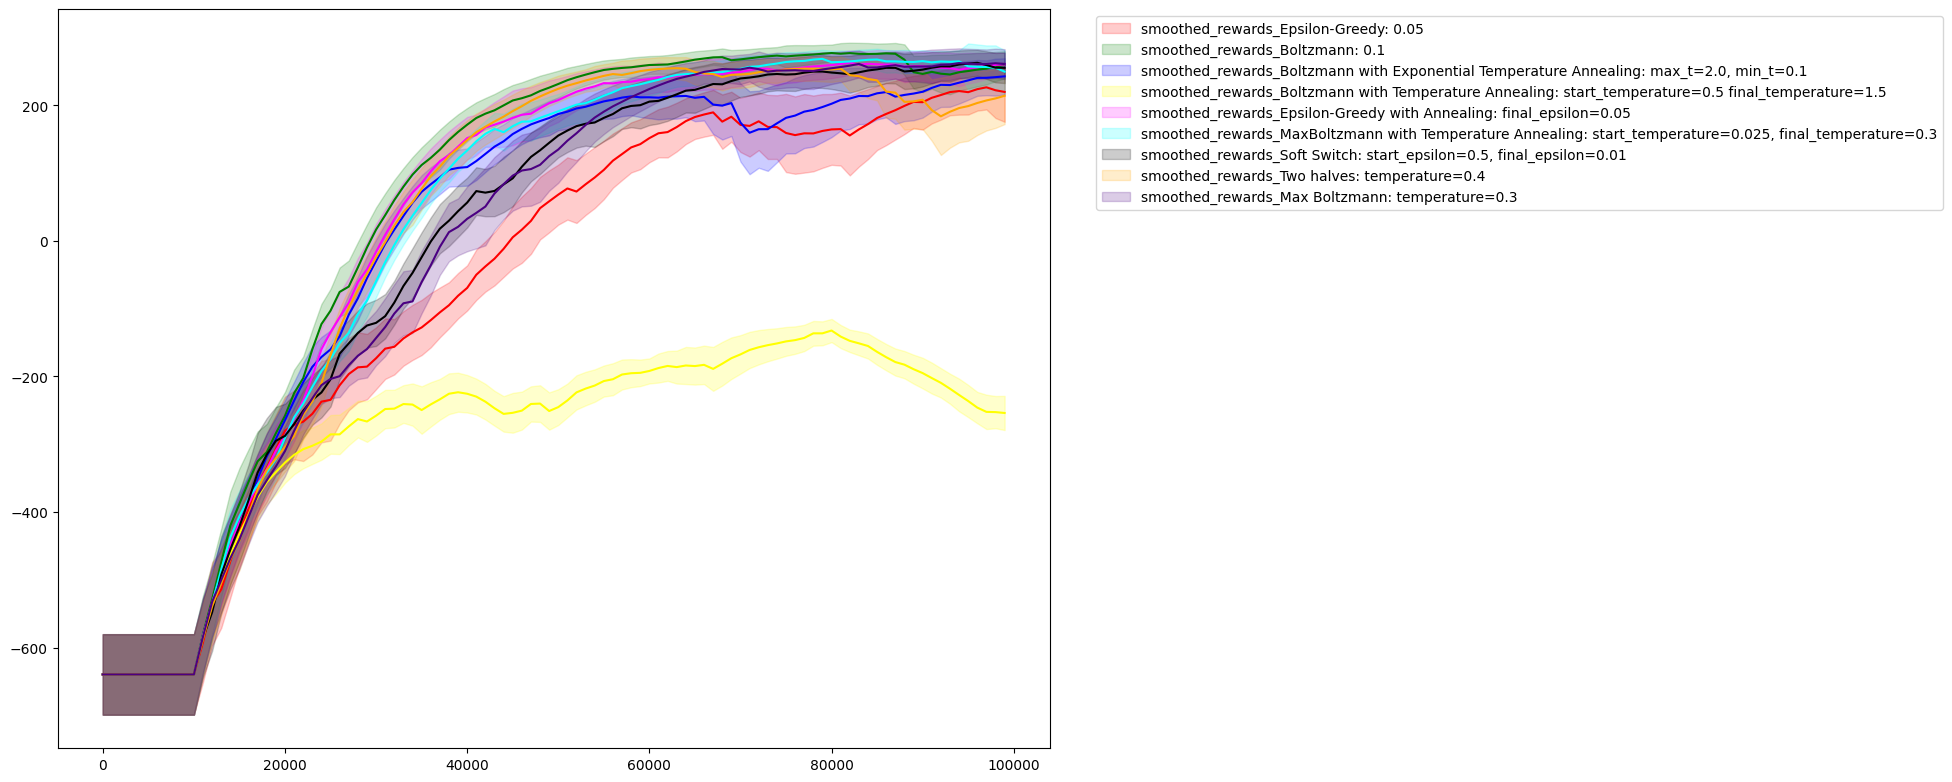

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot_results_many(result_means_list, result_stds_list, names_list, colours_list[:len(names_list)])

In [ ]:
# N = 4
# result_means_list_tmp = result_means_list[:N]
# result_stds_list_tmp = result_stds_list[:N]
# names_list_tmp = names_list[:N]

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -592.09443328 -535.5078223  -514.19579377 -472.6377267
 -429.26206853 -395.28115008 -360.05004405 -334.40331047 -306.73116467
 -280.04896496 -271.51575331 -266.73279623 -255.17478889 -237.18510679
 -234.5545746  -213.00603832 -196.49832144 -186.58213968 -185.50991713
 -173.13778971 -158.99360554 -156.2692291  -143.97625224 -135.00397214
 -127.72895645 -117.00010142 -105.48999195  -94.94458939  -80.92161659
  -69.38890072  -49.96690223  -37.6591574   -26.26855177  -11.69486613
    5.3075674    16.53324276   29.47383883   48.27811832   58.37081478
   68.2549598    77.35755128   72.80466101   83.51040005   93.50673059
  104.72980031  118.40418737  128.0802703   137.91963933  142.72107139
  151.61556094  158.81094214  160.54287124  167.91023292  176.67872558
  182.76069033  186.48401513  189.62820753  175.96226806  183.2191328
  171.19

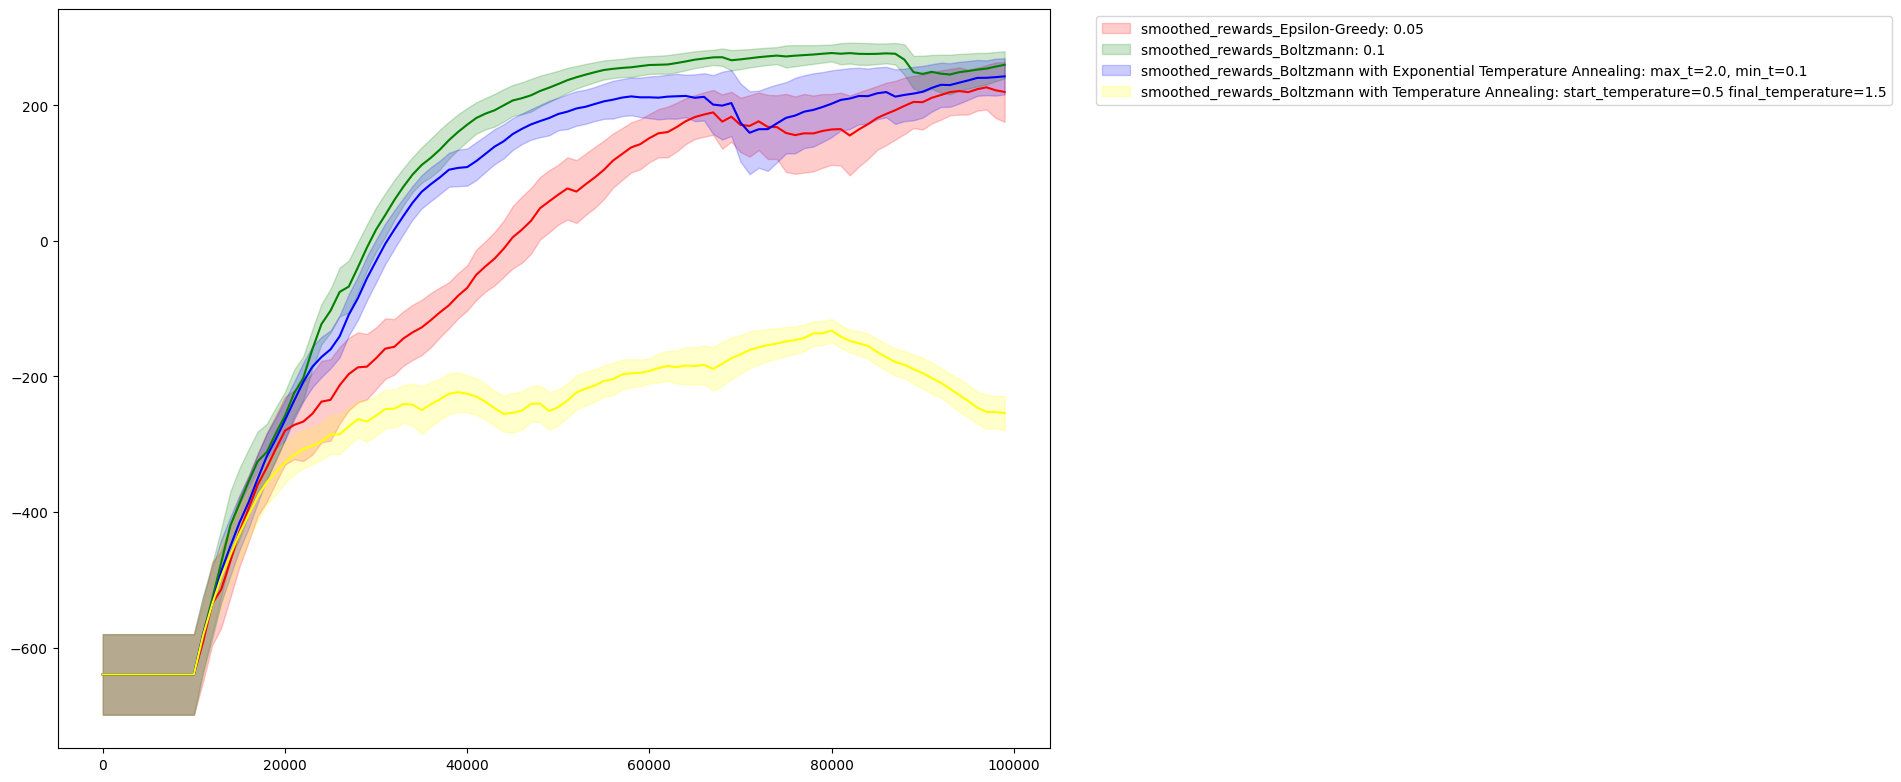

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot_results_many(result_means_list_tmp, result_stds_list_tmp, names_list_tmp, colours_list[:len(names_list_tmp)])

In [ ]:
# result_means_list_tmp = result_means_list[N:]
# result_stds_list_tmp = result_stds_list[N:]
# names_list_tmp = names_list[N:]

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -584.71247847 -533.4772724  -489.53617267 -449.29681556
 -415.30081998 -388.05935047 -359.4676124  -337.19635535 -309.61534078
 -287.48906477 -262.42540522 -235.45150158 -199.69985732 -159.84657511
 -134.66772546 -112.65389823  -91.33313129  -60.86048658  -42.04481964
  -16.07026551    8.87302443   31.7111224    53.70066371   71.37987924
   85.20604843  102.44300665  117.5384922   126.54080683  139.04988297
  151.64458439  156.26135529  167.22380567  171.39016996  176.00397713
  181.50077598  186.08987629  187.67208329  195.80947882  203.080604
  207.70773566  214.07068135  220.12670843  224.55858056  228.02175659
  232.7959217   232.32810114  234.3610287   234.88963934  237.36834928
  238.89307257  241.45473768  240.72473387  243.58978857  244.89009542
  245.17111693  245.88824162  245.72114363  246.4108293   248.13469841
  249.22

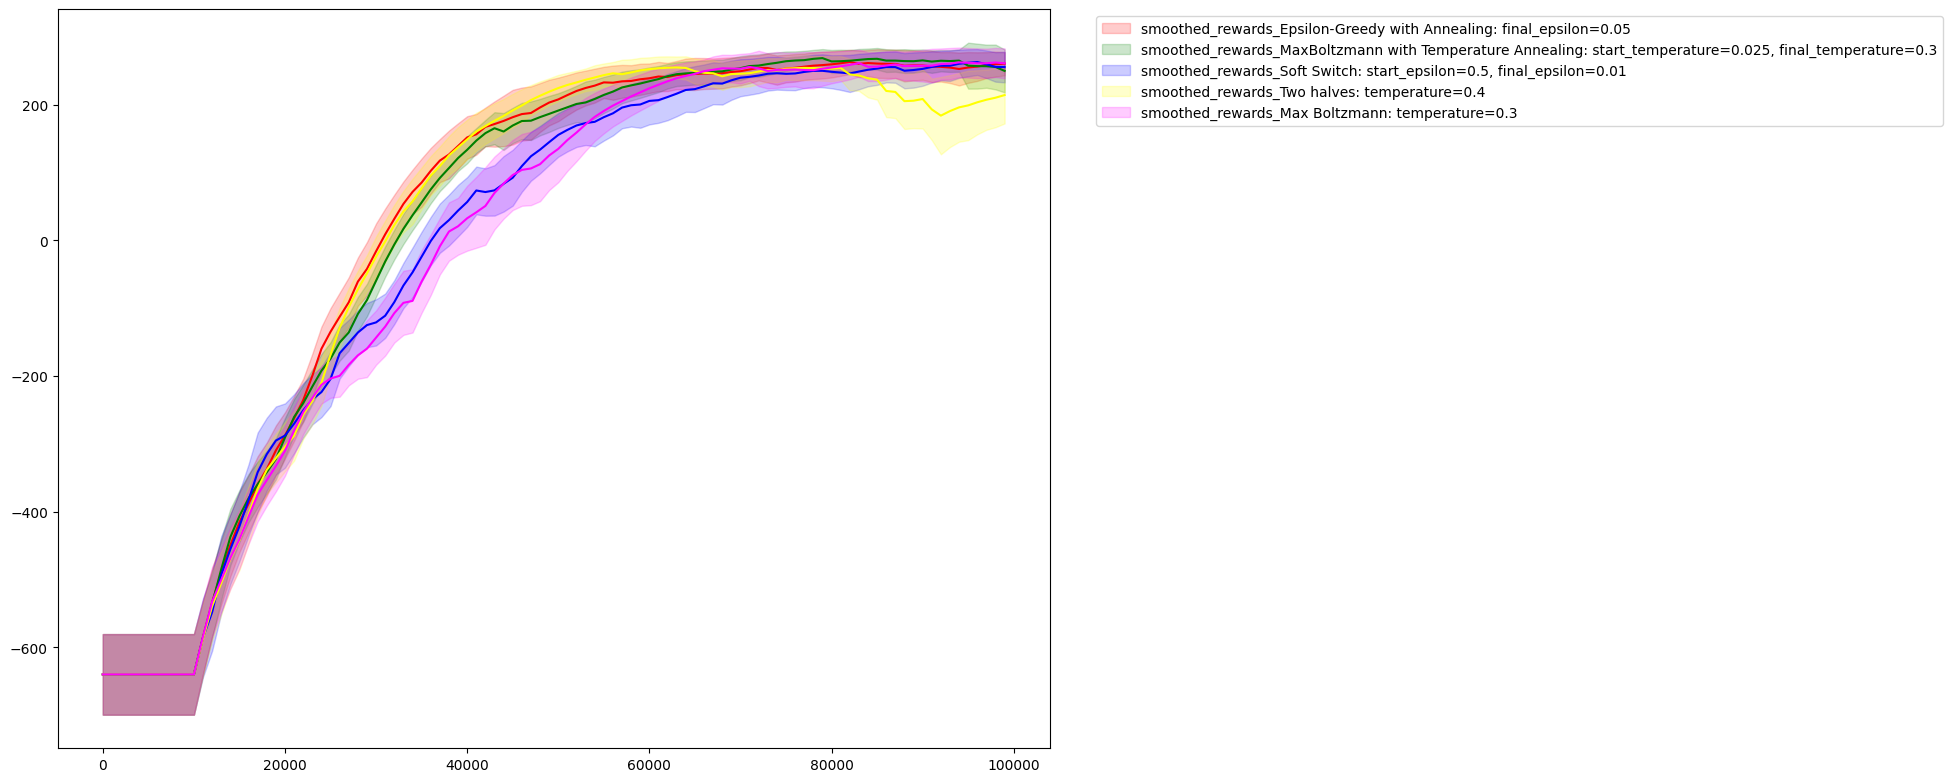

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot_results_many(result_means_list_tmp, result_stds_list_tmp, names_list_tmp, colours_list[:len(names_list_tmp)])

In [ ]:
# def plot_by_ids(ids):
#   means = [result_means_list[i] for i in ids]
#   stds = [result_stds_list[i] for i in ids]
#   names = [names_list[i] for i in ids]
#   colours = [colours_list[i] for i in ids]

#   plot_results_many(means, stds, names, colours)

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -592.09443328 -535.5078223  -514.19579377 -472.6377267
 -429.26206853 -395.28115008 -360.05004405 -334.40331047 -306.73116467
 -280.04896496 -271.51575331 -266.73279623 -255.17478889 -237.18510679
 -234.5545746  -213.00603832 -196.49832144 -186.58213968 -185.50991713
 -173.13778971 -158.99360554 -156.2692291  -143.97625224 -135.00397214
 -127.72895645 -117.00010142 -105.48999195  -94.94458939  -80.92161659
  -69.38890072  -49.96690223  -37.6591574   -26.26855177  -11.69486613
    5.3075674    16.53324276   29.47383883   48.27811832   58.37081478
   68.2549598    77.35755128   72.80466101   83.51040005   93.50673059
  104.72980031  118.40418737  128.0802703   137.91963933  142.72107139
  151.61556094  158.81094214  160.54287124  167.91023292  176.67872558
  182.76069033  186.48401513  189.62820753  175.96226806  183.2191328
  171.19

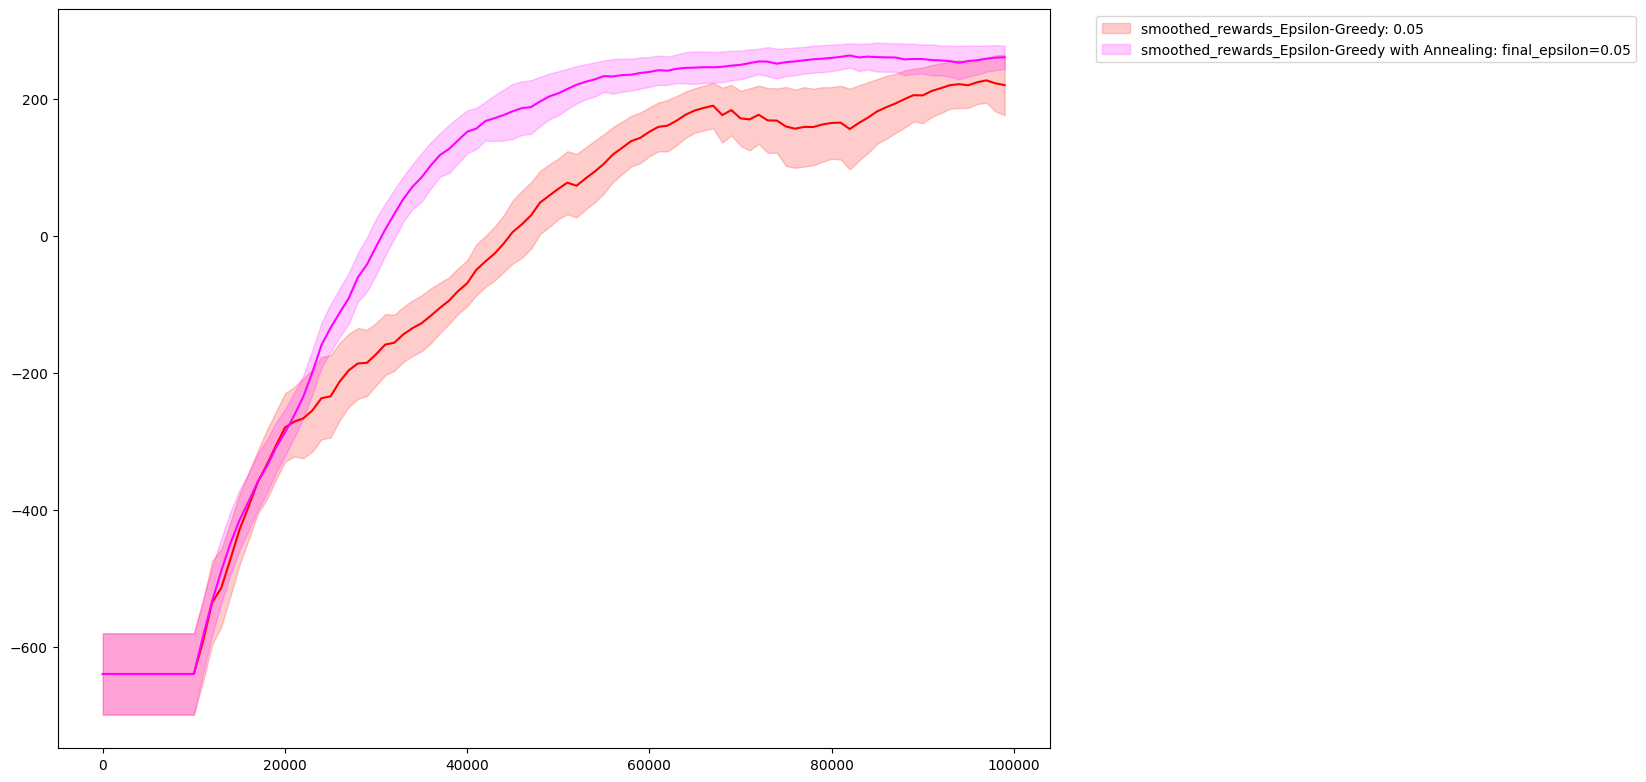

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot_by_ids([0,4])

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -580.37687301 -529.02905252 -474.68450104 -420.17327643
 -387.73993361 -355.42697948 -325.20826514 -311.62213672 -283.77660174
 -258.05056041 -224.6817852  -202.57600738 -160.01027725 -122.79206639
 -102.97460825  -75.27368506  -67.45052776  -39.12198329   -9.70302783
   16.68832606   37.972779     60.19847748   79.95719135   97.7823783
  111.96913664  122.50266598  134.64506918  148.69653048  160.74941911
  171.46628472  181.34220342  187.71740291  192.68538738  199.93816798
  207.18163462  210.52020422  214.76856499  221.1800897   226.11967237
  231.50671305  237.10083602  241.47931591  245.31104918  248.87209208
  252.16276369  253.85723767  255.21521492  256.18098854  257.88322796
  259.51553291  259.87497078  260.30861729  262.43059899  264.80591135
  267.40680792  269.09513218  270.78576432  271.02094341  266.54237852
  267.8

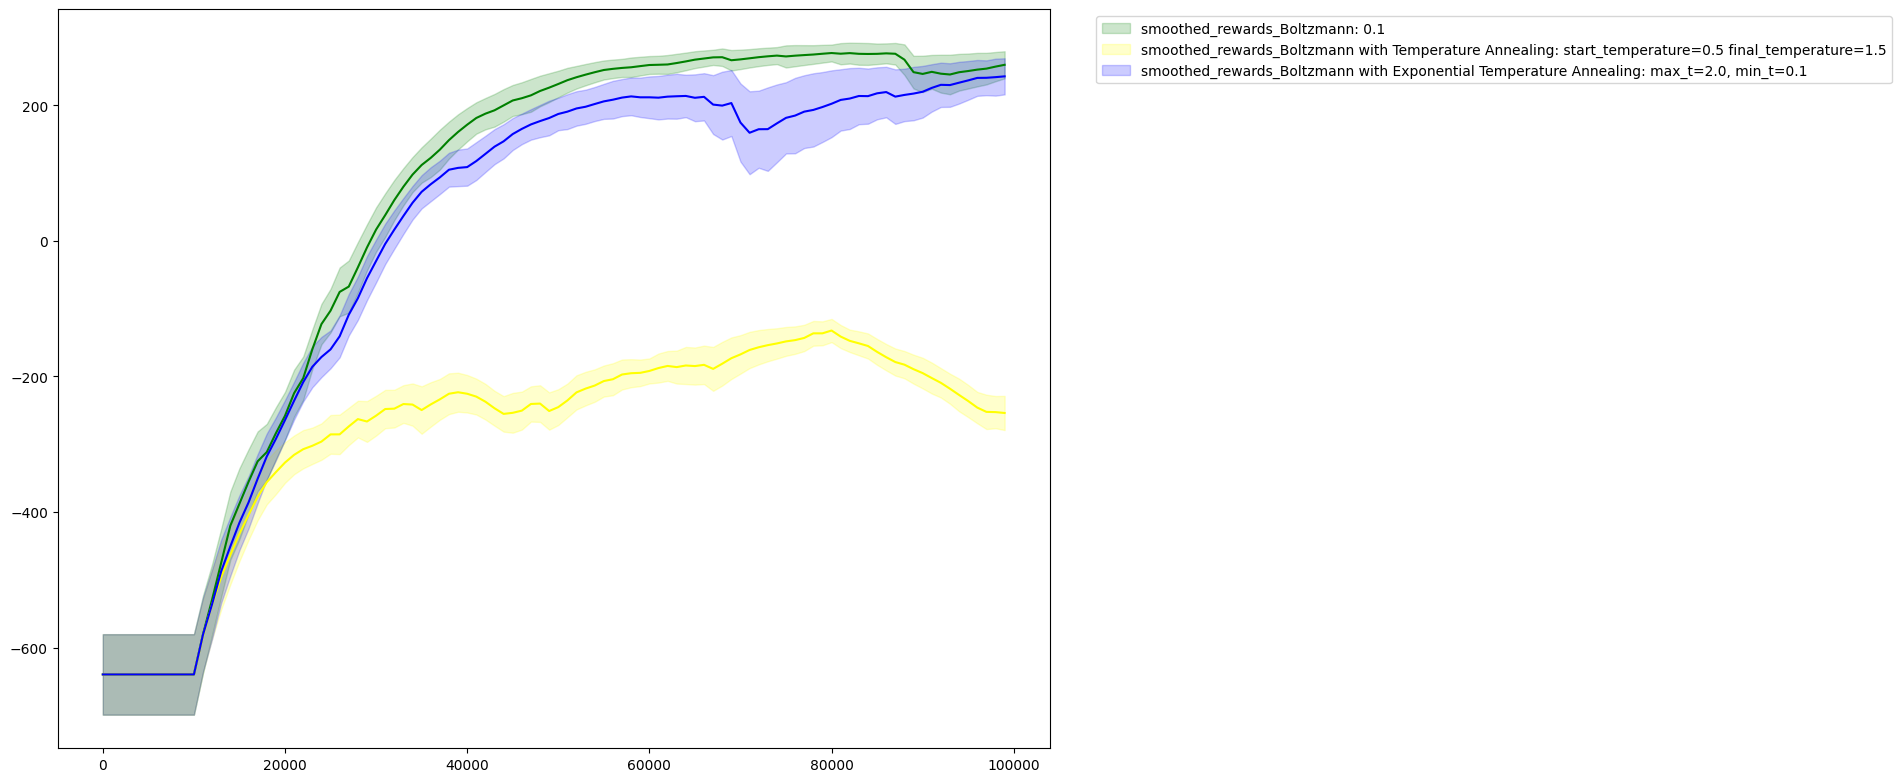

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot_by_ids([1,3,2])

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -583.92990339 -532.62886107 -500.3345652  -468.22902728
 -440.66459748 -407.23687402 -374.85919071 -353.32509247 -332.71340034
 -310.05408579 -280.30403362 -253.14656504 -232.3789063  -212.84021437
 -203.66575233 -199.6586253  -183.41344263 -169.49732582 -159.63825353
 -143.30721161 -127.11854902 -107.25382757  -92.08643715  -89.2691577
  -60.74964202  -36.09311691   -8.79427141   12.9553505    20.75632322
   32.57757334   41.31673288   50.70126091   69.92339638   83.68549117
   96.27431383  103.82711591  105.96479769  112.23989308  125.10367203
  134.82316945  147.79438751  158.80401331  170.97117457  181.93937103
  190.6633755   198.55942379  205.28525654  212.0755538   218.11738706
  224.0801912   229.33821502  234.42922106  238.98873315  242.35033282
  245.39394888  249.32104733  251.38329956  253.56466539  253.10956054
  253.0

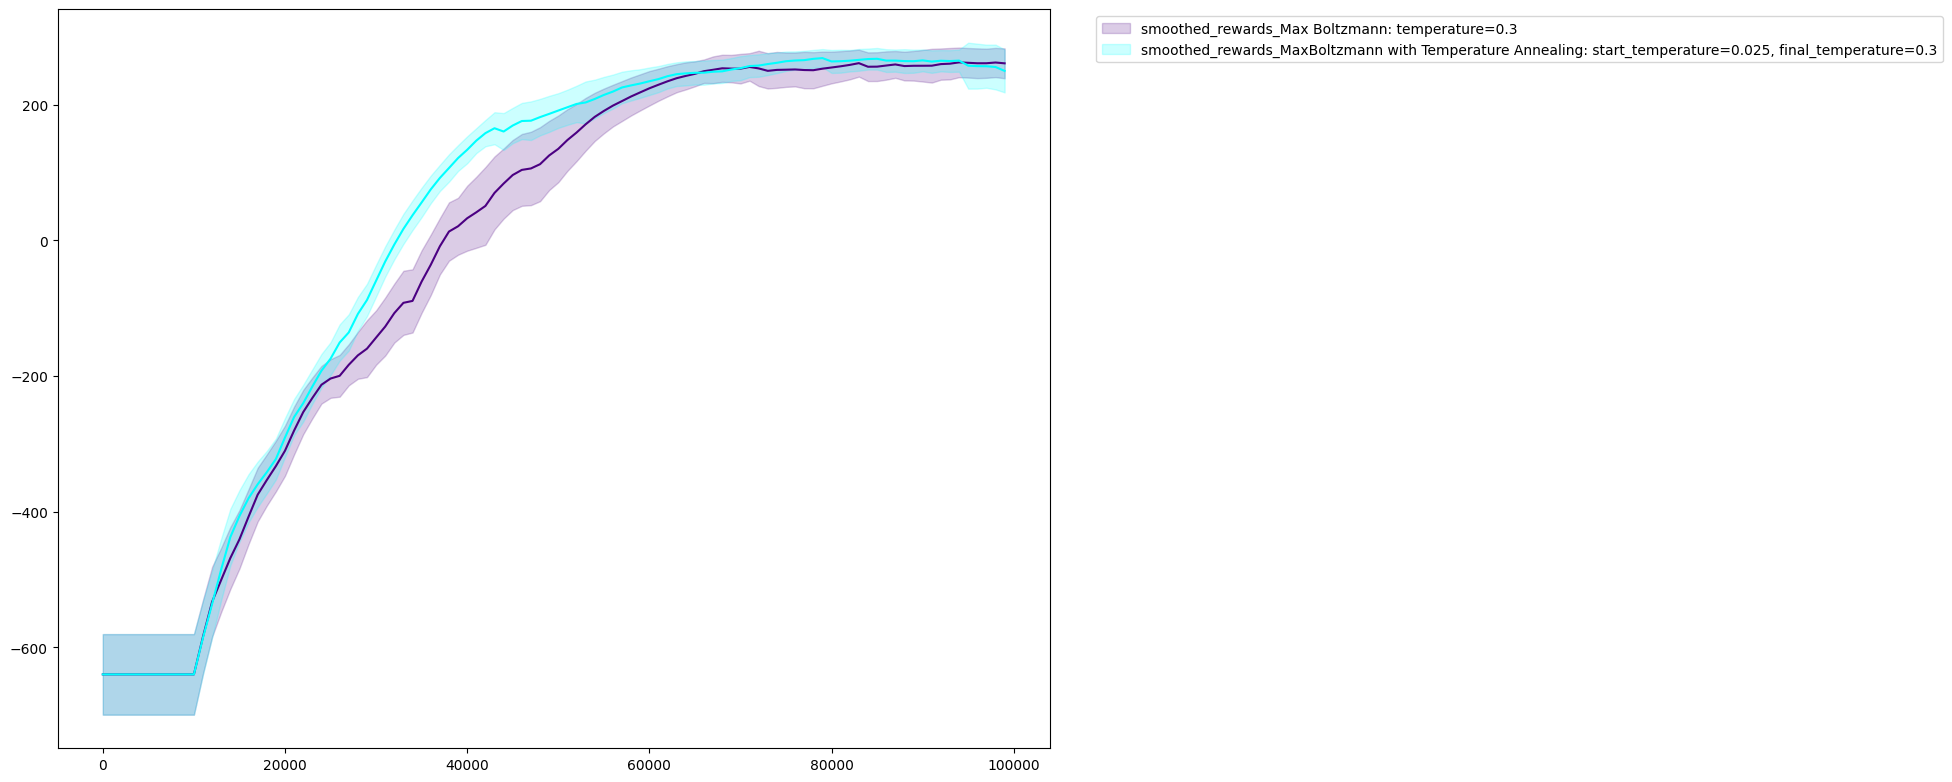

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot_by_ids([8,5])

[-639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -639.69034775 -639.69034775 -639.69034775 -639.69034775
 -639.69034775 -585.52339262 -547.94664403 -492.8149409  -455.17460095
 -421.44049168 -382.70906667 -341.77542772 -315.11949959 -295.04076167
 -287.71937903 -270.2336458  -250.53299259 -234.43504527 -223.64160357
 -204.29855314 -166.42008029 -151.22825319 -135.87263159 -124.87173668
 -120.91487789 -111.07013313  -91.04033344  -66.57221463  -47.19855753
  -24.05670742   -1.01585048   17.97772836   29.83420636   43.86099321
   56.54690963   73.47970772   71.19698659   73.65989922   83.30354323
   92.33051713  109.38361373  123.92510081  133.6765004   144.70278124
  155.41683656  162.78850005  169.30013686  172.83120024  174.68043884
  181.52362704  187.20133065  195.67172518  199.11128104  200.22226631
  205.50272494  206.61670851  211.21114754  216.16390103  221.64154074
  222.89882777  226.96324547  231.47577295  231.01010319  235.86513837
  239.

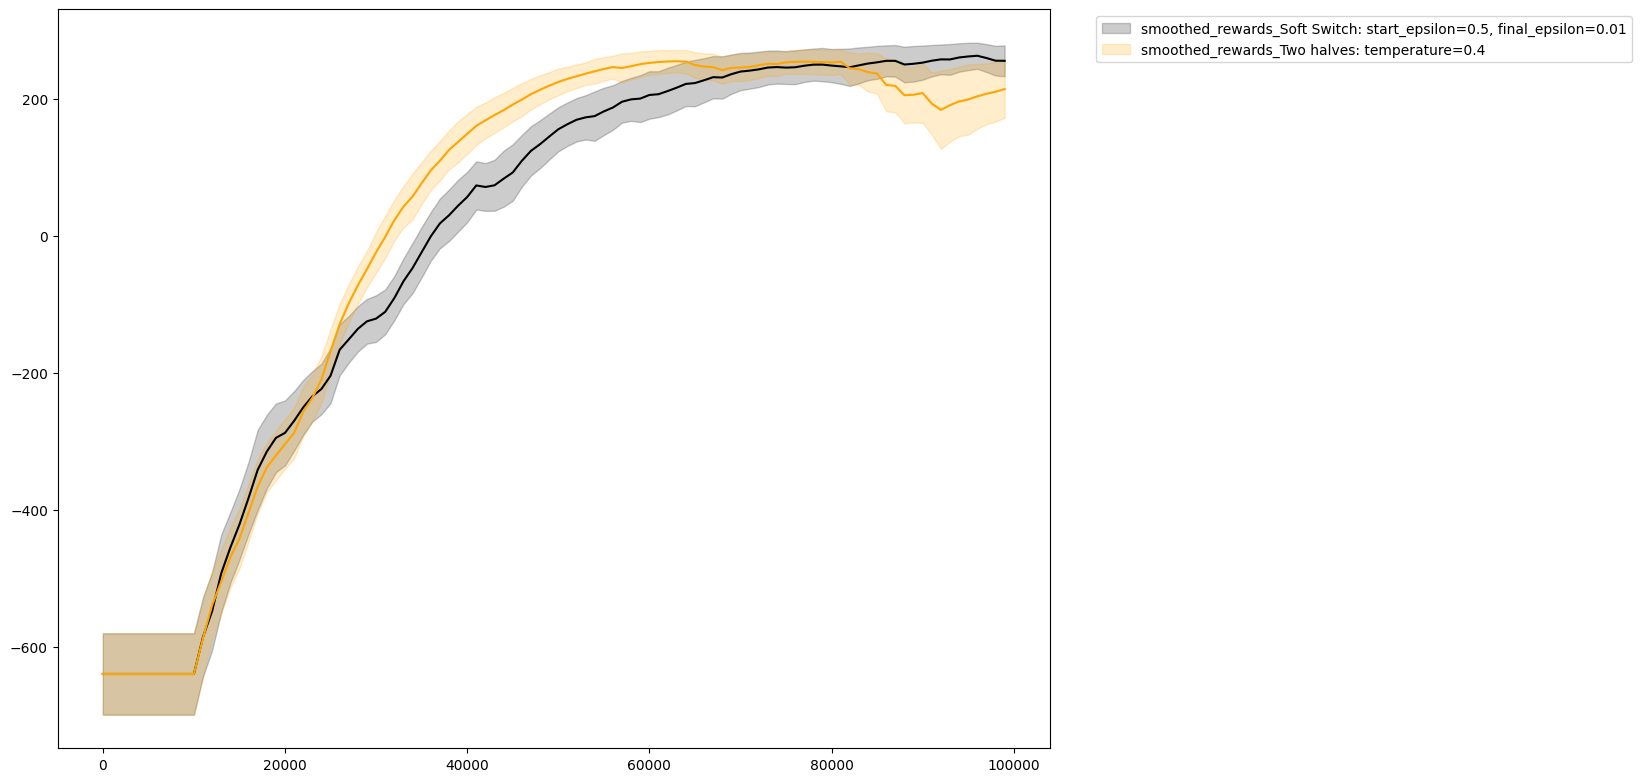

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot_by_ids([6, 7])